Will compare the three best models, pick the best one, check it, and then analyze how it relates to various covariates.

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import json
import hmmlearn
import matplotlib.ticker as mtick
from scipy.stats import tukey_hsd

# load the original obs the models were tested on

In [2]:
# Combine all subjects
print("Loading data...")
with open("../cleaned_data_files/subject_data_for_HMM.json", "r") as f:
    subject_data = json.load(f)
print(f"Loaded {len(subject_data)} subjects")

test_subjects = list(subject_data.keys())#all subjects

all_obs = []
lengths = []
for subject_id in test_subjects:
    subj = subject_data[subject_id]
    accuracy = np.array(subj['epoch_accuracy'])
    rest_duration = np.array(subj['post_epoch_post_cue_rest_duration'])
    obs = np.column_stack([accuracy, rest_duration])
    all_obs.append(obs)
    lengths.append(len(obs))
pooled_obs = np.vstack(all_obs)
print(f"Pooled data shape: {pooled_obs.shape}")
print(f"Subject lengths: {lengths}")
pooled_obs[:, 1] = pooled_obs[:, 1] / 20  # Scale rest to 0-1 range
print(f"Pooled data shape: {pooled_obs.shape}")
print(f"Subject lengths: {lengths}")

Loading data...
Loaded 84 subjects
Pooled data shape: (2520, 2)
Subject lengths: [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
Pooled data shape: (2520, 2)
Subject lengths: [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]


# selecting best model

In [3]:
# Load all models
models_dir = 'pooled_models'
models_data = {}
model_files = {
    '2-state': 'max2s_complete_best_pooled_hmm_analysis.pkl',
    '3-state': 'max3s_complete_best_pooled_hmm_analysis.pkl',
    '4-state': 'max4s_complete_best_pooled_hmm_analysis.pkl', 
    '5-state': 'max5s_complete_best_pooled_hmm_analysis.pkl',
    '6-state': 'max6s_complete_best_pooled_hmm_analysis.pkl'
}

print("Loading saved models...")
for name, filename in model_files.items():
    full_file = f"{models_dir}/{filename}"
    try:
        with open(full_file, 'rb') as f:
            models_data[name] = pickle.load(f)
        print(f"Loaded {name} model")
    except Exception as e:
        print(f"Failed to load {name}: {e}")

if not models_data:
    print("No models loaded successfully!")
    
# Extract key information
comparison_results = {}

Loading saved models...
Loaded 2-state model
Loaded 3-state model
Loaded 4-state model
Loaded 5-state model
Loaded 6-state model


In [4]:
print("\n" + "="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)

for name, data in models_data.items():
    model = data['model']
    
    # Basic info
    n_states = model.n_components
    score = data.get('score', data.get('performance', {}).get('log_likelihood', 'Unknown'))
    converged = model.monitor_.converged
    
    # Calculate parameters (for AIC/BIC)
    n_params = (n_states * n_states +          # transition matrix
               n_states * 2 * 2 +             # emission means (2 features)
               n_states * 3 +                 # covariance params (full)
               n_states - 1)                  # initial probs (n-1 free params)
    
    comparison_results[name] = {
        'n_states': n_states,
        'log_likelihood': score,
        'converged': converged,
        'n_params': n_params,
        'model': model,
        'data_context': data.get('data_context', {}),
        'means': model.means_,
        'transitions': model.transmat_
    }
    
    # Calculate AIC and BIC
    if isinstance(score, (int, float)):
        aic = -2 * score + 2 * n_params
        bic = -2 * score + np.log(2520) * n_params  # Assuming ~2520 observations
        comparison_results[name]['aic'] = aic
        comparison_results[name]['bic'] = bic
    
    print(f"\n{name.upper()} MODEL:")
    print(f"  States: {n_states}")
    print(f"  Log-likelihood: {score}")
    print(f"  Converged: {converged}")
    print(f"  Parameters: {n_params}")
    if isinstance(score, (int, float)):
        print(f"  AIC: {aic:.2f}")
        print(f"  BIC: {bic:.2f}")


MODEL COMPARISON SUMMARY

2-STATE MODEL:
  States: 2
  Log-likelihood: 1629.4924888615164
  Converged: True
  Parameters: 19
  AIC: -3220.98
  BIC: -3110.18

3-STATE MODEL:
  States: 3
  Log-likelihood: 3357.698192540759
  Converged: True
  Parameters: 32
  AIC: -6651.40
  BIC: -6464.77

4-STATE MODEL:
  States: 4
  Log-likelihood: 5323.097546658377
  Converged: True
  Parameters: 47
  AIC: -10552.20
  BIC: -10278.09

5-STATE MODEL:
  States: 5
  Log-likelihood: 5798.579243746978
  Converged: True
  Parameters: 64
  AIC: -11469.16
  BIC: -11095.91

6-STATE MODEL:
  States: 6
  Log-likelihood: 6335.37871724057
  Converged: True
  Parameters: 83
  AIC: -12504.76
  BIC: -12020.70


In [5]:
# Model selection based on information criteria
print("\n" + "="*50)
print("MODEL SELECTION CRITERIA")
print("="*50)

# Find best model by different criteria
valid_models = {name: data for name, data in comparison_results.items() 
               if isinstance(data['log_likelihood'], (int, float))}

if valid_models:
    best_ll = max(valid_models.keys(), key=lambda x: valid_models[x]['log_likelihood'])
    best_aic = min(valid_models.keys(), key=lambda x: valid_models[x]['aic'])
    best_bic = min(valid_models.keys(), key=lambda x: valid_models[x]['bic'])
    
    print(f"Best by Log-Likelihood: {best_ll}")
    print(f"Best by AIC (complexity penalty): {best_aic}")
    print(f"Best by BIC (stronger penalty): {best_bic}")
    
    # Check if they agree
    if best_aic == best_bic:
        print(f"\n {best_aic} model is best by both AIC and BIC")
    else:
        print(f"\n AIC favors {best_aic}, BIC favors {best_bic}")


MODEL SELECTION CRITERIA
Best by Log-Likelihood: 6-state
Best by AIC (complexity penalty): 6-state
Best by BIC (stronger penalty): 6-state

 6-state model is best by both AIC and BIC


In [6]:
# Detailed state analysis
print("\n" + "="*50)
print("STATE CHARACTERISTICS COMPARISON")
print("="*50)

for name, data in comparison_results.items():
    model = data['model']
    n_states = data['n_states']
    
    print(f"\n{name.upper()} - STATE MEANS:")
    
    # Convert rest back to original scale (assuming /20 scaling)
    scaling_factor = data.get('data_context', {}).get('scaling_factor', 20)
    
    # Sort states by rest duration for consistent comparison
    rest_means = model.means_[:, 1] * scaling_factor
    state_order = np.argsort(rest_means)
    
    for idx, state_idx in enumerate(state_order):
        acc = model.means_[state_idx, 0]
        rest = rest_means[state_idx]
        
        # Assign interpretable names
        if n_states == 3:
            state_names = ["FOCUSED", "INTERMEDIATE", "FATIGUE"]
        elif n_states == 4:
            state_names = ["FOCUSED", "MILD-FATIGUE", "MODERATE-FATIGUE", "SEVERE-FATIGUE"]
        elif n_states == 5:
            state_names = ["FOCUSED", "LIGHT-FATIGUE", "MILD-FATIGUE", "MODERATE-FATIGUE", "SEVERE-FATIGUE"]
        else:
            state_names = [f"STATE-{i+1}" for i in range(n_states)]
        
        state_name = state_names[idx] if idx < len(state_names) else f"STATE-{idx+1}"
        print(f"  {state_name}: accuracy={acc:.3f}, rest={rest:.1f} trials")

# State usage analysis
print("\n" + "="*70)
print("STATE USAGE ANALYSIS")
print("="*70)

#show transition patterns
for name, data in comparison_results.items():
    model = data['model']
    print(f"\n{name.upper()} - TRANSITION PERSISTENCE:")
    
    diagonal_values = np.diag(model.transmat_)
    for i, persistence in enumerate(diagonal_values):
        print(f"  State {i}: {persistence:.3f} ({persistence*100:.1f}% stay)")
    
    # Check for reasonable persistence
    reasonable_states = np.sum((diagonal_values > 0.3) & (diagonal_values < 0.99))
    print(f"  States with reasonable persistence: {reasonable_states}/{len(diagonal_values)}")


STATE CHARACTERISTICS COMPARISON

2-STATE - STATE MEANS:
  STATE-1: accuracy=0.770, rest=4.3 trials
  STATE-2: accuracy=0.657, rest=20.0 trials

3-STATE - STATE MEANS:
  FOCUSED: accuracy=0.913, rest=1.2 trials
  INTERMEDIATE: accuracy=0.670, rest=6.4 trials
  FATIGUE: accuracy=0.657, rest=20.0 trials

4-STATE - STATE MEANS:
  FOCUSED: accuracy=0.901, rest=1.0 trials
  MILD-FATIGUE: accuracy=0.816, rest=6.2 trials
  MODERATE-FATIGUE: accuracy=0.000, rest=6.7 trials
  SEVERE-FATIGUE: accuracy=0.682, rest=20.0 trials

5-STATE - STATE MEANS:
  FOCUSED: accuracy=0.901, rest=1.0 trials
  LIGHT-FATIGUE: accuracy=0.922, rest=4.5 trials
  MILD-FATIGUE: accuracy=0.687, rest=8.2 trials
  MODERATE-FATIGUE: accuracy=0.000, rest=8.8 trials
  SEVERE-FATIGUE: accuracy=0.728, rest=20.0 trials

6-STATE - STATE MEANS:
  STATE-1: accuracy=0.896, rest=1.0 trials
  STATE-2: accuracy=0.005, rest=5.4 trials
  STATE-3: accuracy=0.629, rest=5.8 trials
  STATE-4: accuracy=0.875, rest=6.4 trials
  STATE-5: accu

In [7]:
# check how often 4,5,and 6 use the 0 accuracy states
predicted_states = models_data['4-state']['model'].predict(pooled_obs, lengths=lengths)
state_counts = np.bincount(predicted_states, minlength=2)
for i, count in enumerate(state_counts):
    print(f"State {i}: {count} observations ({count/len(predicted_states)*100:.1f}%)")

print(f"Minimum accuracy in data: {pooled_obs[:, 0].min()}")
print(f"Observations with accuracy < 0.1: {np.sum(pooled_obs[:, 0] < 0.1)}")

State 0: 197 observations (7.8%)
State 1: 588 observations (23.3%)
State 2: 1061 observations (42.1%)
State 3: 674 observations (26.7%)
Minimum accuracy in data: 0.0
Observations with accuracy < 0.1: 260


*Analyis: **5-state model** seems like its the best mathematically + is still interpretable, but **3-state model** seems like it has the best interpretability. 6-state model doesnt use all the states as equally and is also less interpretable.* 

# 3-State model

In [8]:
curr_model = models_data['3-state']['model']

In [9]:
rest_means = curr_model.means_[:, 1] * scaling_factor
state_order = np.argsort(rest_means)

for idx, state_idx in enumerate(state_order):
    acc = curr_model.means_[state_idx, 0]
    rest = rest_means[state_idx]
    
    state_name = state_names[idx] if idx < len(state_names) else f"STATE-{idx+1}"
    print(f"  {state_name}: accuracy={acc:.3f}, rest={rest:.1f} trials")


  STATE-1: accuracy=0.913, rest=1.2 trials
  STATE-2: accuracy=0.670, rest=6.4 trials
  STATE-3: accuracy=0.657, rest=20.0 trials


Load the model and predict per subject

In [10]:

subject_state_sequences = {}
for subject_id in test_subjects:
    subj = subject_data[subject_id]
    accuracy = np.array(subj['epoch_accuracy'])
    rest_duration = np.array(subj['post_epoch_post_cue_rest_duration']) / 20
    obs = np.column_stack([accuracy, rest_duration])
    state_seq = curr_model.predict(obs)
    subject_state_sequences[subject_id] = state_seq

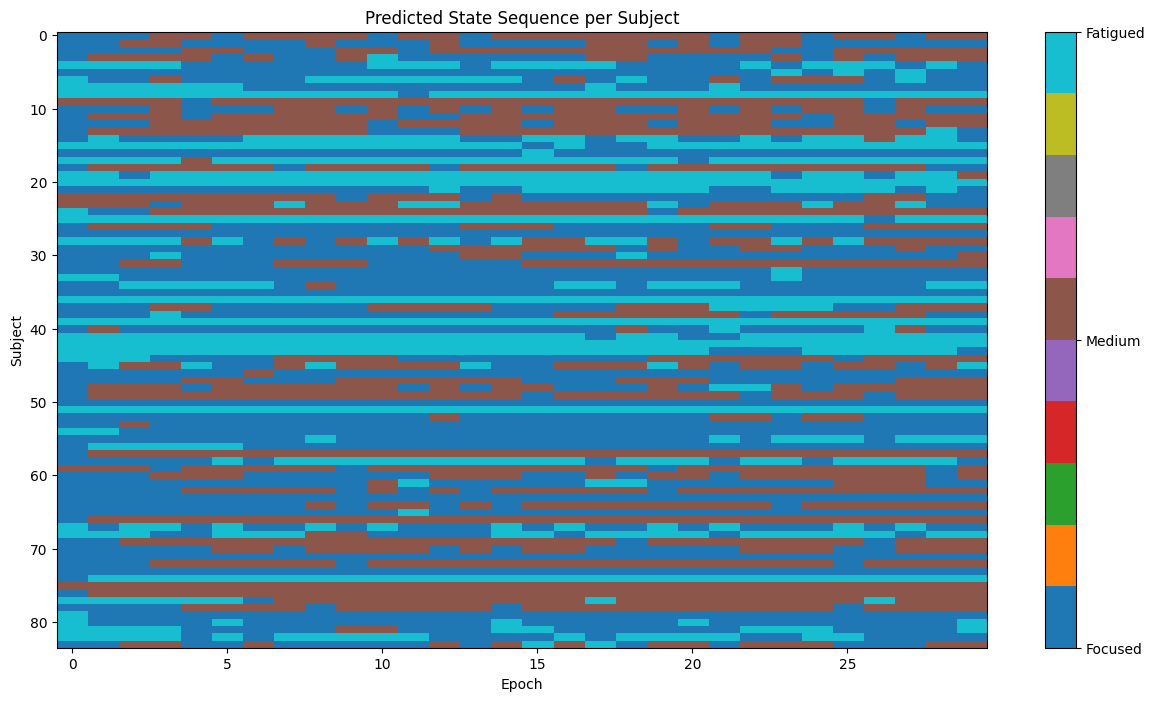

In [11]:
# Build a matrix: rows=subjects, cols=epochs, values=state
n_subjects = len(test_subjects)
n_epochs = len(next(iter(subject_state_sequences.values())))
state_matrix = np.zeros((n_subjects, n_epochs), dtype=int)

for i, subject_id in enumerate(test_subjects):
    state_matrix[i, :] = subject_state_sequences[subject_id]

plt.figure(figsize=(15, 8))
im = plt.imshow(state_matrix, aspect='auto', cmap='tab10', vmin=0, vmax=2)
cbar = plt.colorbar(im, ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['Focused', 'Medium', 'Fatigued'])  # or your own labels
plt.xlabel('Epoch')
plt.ylabel('Subject')
plt.title('Predicted State Sequence per Subject')
plt.show()

recovery
 0    1897
-1     280
 1     259
Name: count, dtype: int64
           count       mean       std  min   25%  50%   75%   max
recovery                                                         
-1         280.0   6.282143  5.029914  1.0  2.75  5.0   9.0  19.0
 0        1897.0   8.046916  7.660547  1.0  1.00  5.0  18.0  20.0
 1         259.0  10.281853  9.408973  1.0  1.00  2.0  20.0  20.0


/var/folders/xn/lkw6x82n60l07h4hbhyrhyh40000gn/T/ipykernel_49238/1515870100.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = rest_recovery_df.groupby('recovery_cat')['rest'].mean()


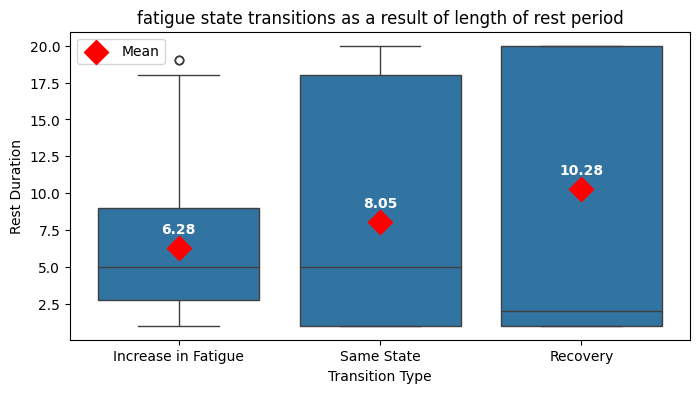

In [12]:
# (least to most fatigued)
fatigue_order = [0, 1, 2]

# collect rest durations and transitions
rest_recovery = []
for subject_id in test_subjects:
    subj = subject_data[subject_id]
    rest = np.array(subj['post_epoch_post_cue_rest_duration'])
    state_seq = subject_state_sequences[subject_id]
    for t in range(len(rest) - 1):
        from_state = state_seq[t]
        to_state = state_seq[t + 1]
        rest_now = rest[t]

        if fatigue_order.index(to_state) < fatigue_order.index(from_state):
            recovery = 1  # transition to less fatigue (recovery)
        elif fatigue_order.index(to_state) > fatigue_order.index(from_state):
            recovery = -1 # transition to more fatigue
        else:
            recovery = 0  # same fatigue
        rest_recovery.append({'rest': rest_now, 'recovery': recovery})

rest_recovery_df = pd.DataFrame(rest_recovery)

# print info on the df
print(rest_recovery_df['recovery'].value_counts())
print(rest_recovery_df.groupby('recovery')['rest'].describe())

# plot the recoery states as a block plot
plt.figure(figsize=(8, 4))
cat_order = [-1, 0, 1]
cat_labels = ['Increase in Fatigue', 'Same State', 'Recovery']
rest_recovery_df['recovery_cat'] = pd.Categorical(rest_recovery_df['recovery'], categories=cat_order, ordered=True)
ax = sns.boxplot(x='recovery_cat', y='rest', data=rest_recovery_df, order=cat_order)
means = rest_recovery_df.groupby('recovery_cat')['rest'].mean()
# Plot means
for i, mean in enumerate(means):
    plt.scatter(i, mean, color='red', marker='D', s=150, zorder=10, label='Mean' if i == 0 else "")
    plt.text(i, mean + 1, f"{mean:.2f}", color='white', ha='center', fontweight='bold', zorder=11)
plt.xticks([0, 1, 2], cat_labels)
plt.title('fatigue state transitions as a result of length of rest period')
plt.xlabel('Transition Type')
plt.ylabel('Rest Duration')
plt.legend()
plt.show()

# 5-State model

In [13]:
curr_model = models_data['5-state']['model']

In [17]:
rest_means = curr_model.means_[:, 1] * scaling_factor
acc_means = curr_model.means_[:, 0]

for i, _ in enumerate(rest_means):
    acc = acc_means[i]
    rest = rest_means[i]
    
    state_name = f"STATE-{i}"
    print(f"  {state_name}: accuracy={acc:.3f}, rest={rest:.1f} trials")


  STATE-0: accuracy=0.901, rest=1.0 trials
  STATE-1: accuracy=0.687, rest=8.2 trials
  STATE-2: accuracy=0.000, rest=8.8 trials
  STATE-3: accuracy=0.922, rest=4.5 trials
  STATE-4: accuracy=0.728, rest=20.0 trials


  STATE-0: accuracy=0.901, rest=1.0 trials
  STATE-1: accuracy=0.687, rest=8.2 trials
  STATE-2: accuracy=0.000, rest=8.8 trials
  STATE-3: accuracy=0.922, rest=4.5 trials
  STATE-4: accuracy=0.728, rest=20.0 trials
[[9.00597263e-01 5.00000000e-02]
 [9.21718273e-01 2.25874147e-01]
 [6.87233922e-01 4.08359946e-01]
 [7.28132732e-01 1.00000000e+00]
 [1.23984357e-50 4.39222462e-01]]
not fatigued: accuracy=0.901, rest=0.1 trials
mildly fatigued: accuracy=0.922, rest=0.2 trials
medium fatigued: accuracy=0.687, rest=0.4 trials
very fatigued: accuracy=0.728, rest=1.0 trials
given up: accuracy=0.000, rest=0.4 trials


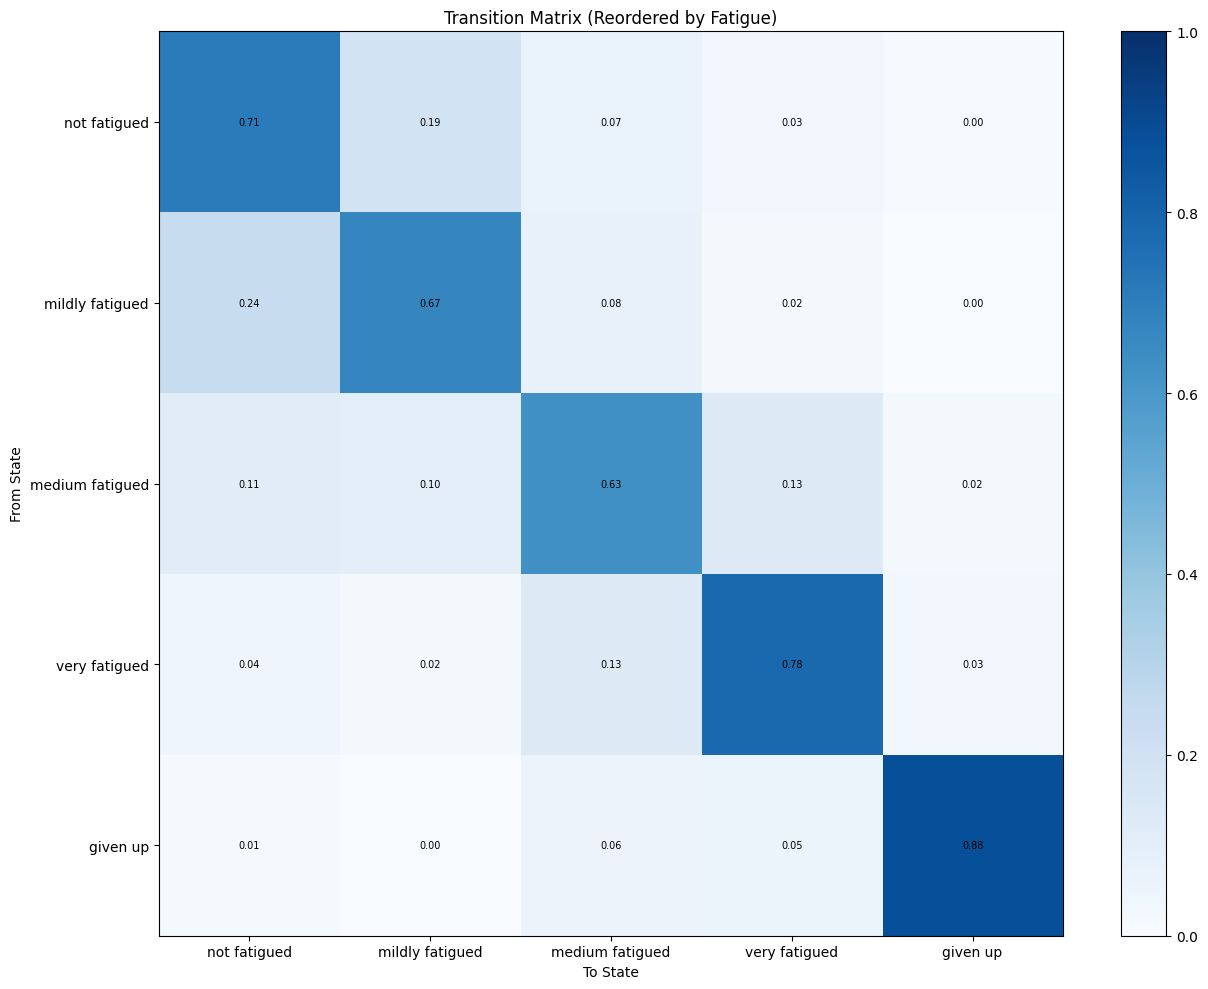

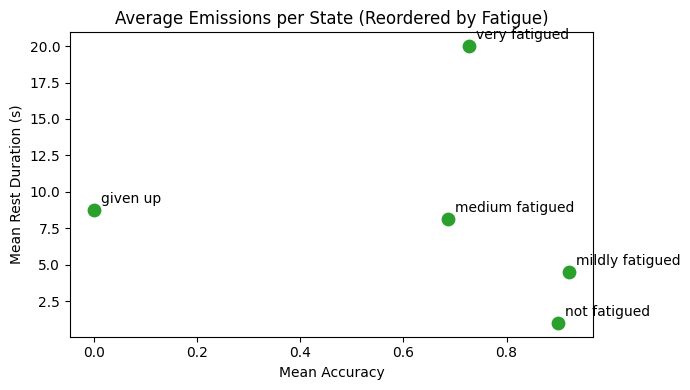

In [23]:
curr_model = models_data['5-state']['model']
rest_means = curr_model.means_[:, 1] * scaling_factor
acc_means = curr_model.means_[:, 0]
# state_order = np.argsort(acc_means)

for i, _ in enumerate(rest_means):
    acc = acc_means[i]
    rest = rest_means[i]
    
    state_name = f"STATE-{i}"
    print(f"  {state_name}: accuracy={acc:.3f}, rest={rest:.1f} trials")

# original ordering: 
#   STATE-0: accuracy=0.901, rest=1.0 trials
#   STATE-1: accuracy=0.687, rest=8.2 trials
#   STATE-2: accuracy=0.000, rest=8.8 trials
#   STATE-3: accuracy=0.922, rest=4.5 trials
#   STATE-4: accuracy=0.728, rest=20.0 trials

# Get fatigue order (from least to most fatigued)
fatigue_order = [0,3,1,4,2]
fatigue_labels = ["not fatigued","mildly fatigued","medium fatigued","very fatigued","given up"]

# Reorder transition matrix
transmat = curr_model.transmat_
transmat_reordered = transmat[np.ix_(fatigue_order, fatigue_order)]

# Reorder means and covariances
means_reordered = curr_model.means_[fatigue_order]
print(means_reordered)
if hasattr(curr_model, "covars_"):
    covars_reordered = curr_model.covars_[fatigue_order]
else:
    covars_reordered = None

# print re-ordered
for i, _ in enumerate(means_reordered):
    acc = means_reordered[i,0]
    rest = means_reordered[i,1]
    
    state_name = f"{fatigue_labels[i]}"
    print(f"{state_name}: accuracy={acc:.3f}, rest={rest:.1f} trials")

# Plot transition matrix
plt.figure(figsize=(15, 10))
im = plt.imshow(transmat_reordered, cmap="Blues", vmin=0, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Transition Matrix (Reordered by Fatigue)")
plt.xlabel("To State")
plt.ylabel("From State")
plt.xticks(range(len(fatigue_order)), [f"{fatigue_labels[i]}" for i in range(len(fatigue_order))])
plt.yticks(range(len(fatigue_order)), [f"{fatigue_labels[i]}" for i in range(len(fatigue_order))])
for i in range(len(fatigue_order)):
    for j in range(len(fatigue_order)):
        plt.text(j, i, f"{transmat_reordered[i, j]:.2f}", ha="center", va="center", color="k", fontsize=7)
plt.tight_layout()
plt.show()

# Plot average emissions per state (reordered)
fig, ax = plt.subplots(figsize=(7, 4))
acc_means = means_reordered[:, 0]
rest_means_plot = means_reordered[:, 1] * scaling_factor

scatter = ax.scatter(acc_means, rest_means_plot, color='C2', s=80)

# Annotate each point
for i, (x, y) in enumerate(zip(acc_means, rest_means_plot)):
    ax.annotate(f"{fatigue_labels[i]}", (x, y), textcoords="offset points", xytext=(5,5), ha='left', fontsize=10)

ax.set_xlabel("Mean Accuracy")
ax.set_ylabel("Mean Rest Duration (s)")
ax.set_title("Average Emissions per State (Reordered by Fatigue)")
plt.tight_layout()
plt.show()


In [24]:
# mapping from original states to reordered states
original_to_reordered = {original: reordered for reordered, original in enumerate(fatigue_order)}

subject_state_sequences = {}
for subject_id in test_subjects:
    subj = subject_data[subject_id]
    accuracy = np.array(subj['epoch_accuracy'])
    rest_duration = np.array(subj['post_epoch_post_cue_rest_duration']) / 20
    obs = np.column_stack([accuracy, rest_duration])
    
    # Get original state sequence
    original_state_seq = curr_model.predict(obs)
    
    # Map to reordered states
    reordered_state_seq = np.array([original_to_reordered[state] for state in original_state_seq])
    
    # Store the reordered sequence
    subject_state_sequences[subject_id] = reordered_state_seq

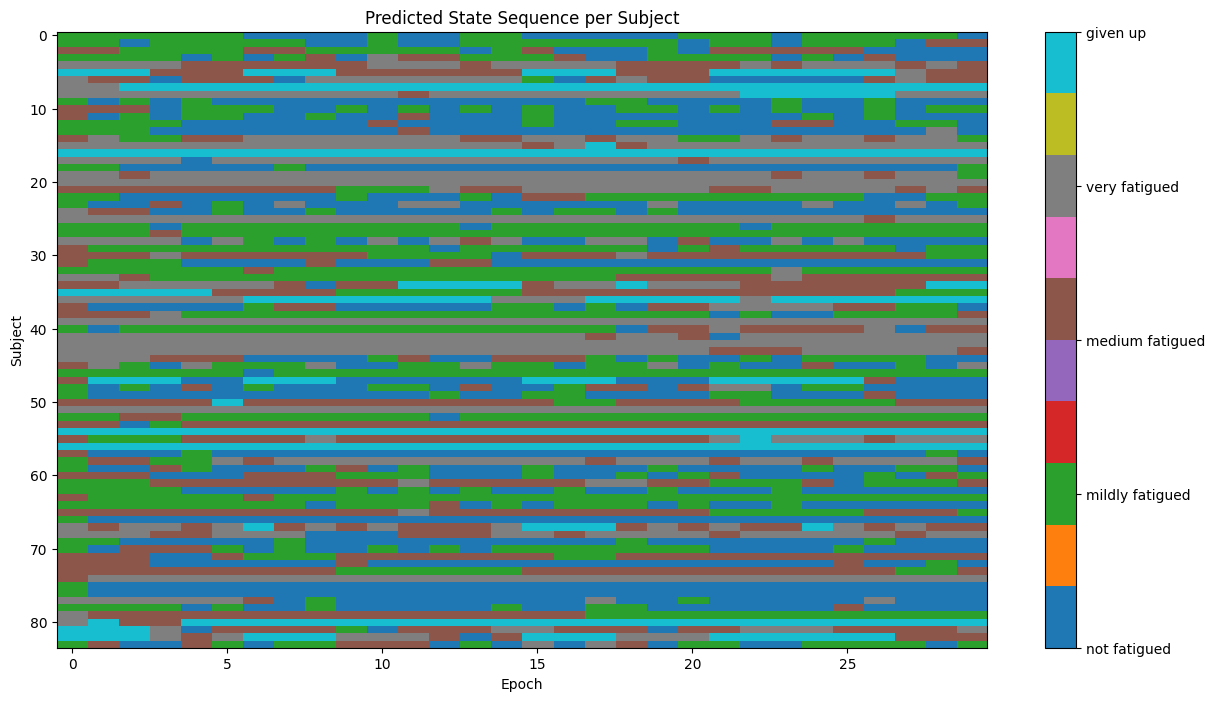

In [26]:
# Build a matrix: rows=subjects, cols=epochs, values=state
n_subjects = len(test_subjects)
n_epochs = len(next(iter(subject_state_sequences.values())))
state_matrix = np.zeros((n_subjects, n_epochs), dtype=int)

for i, subject_id in enumerate(test_subjects):
    state_matrix[i, :] = subject_state_sequences[subject_id]

plt.figure(figsize=(15, 8))
im = plt.imshow(state_matrix, aspect='auto', cmap='tab10')
cbar = plt.colorbar(im, ticks=[0, 1, 2, 3, 4])
cbar.ax.set_yticklabels(fatigue_labels) 
plt.xlabel('Epoch')
plt.ylabel('Subject')
plt.title('Predicted State Sequence per Subject')
plt.show()

/var/folders/xn/lkw6x82n60l07h4hbhyrhyh40000gn/T/ipykernel_61282/1490589511.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/var/folders/xn/lkw6x82n60l07h4hbhyrhyh40000gn/T/ipykernel_61282/1490589511.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(



Tukey's HSD Post-hoc Test Results:
                                          Comparison  Mean Difference  \
0  Transitions to a More Fatigued State vs. Remai...         4.574818   
1  Transitions to a More Fatigued State vs. Trans...         6.019382   
2  Remains in the Same State vs. Transitions to a...         1.444564   

    p-value Significance  
0  0.000000          ***  
1  0.000000          ***  
2  0.002446           **  


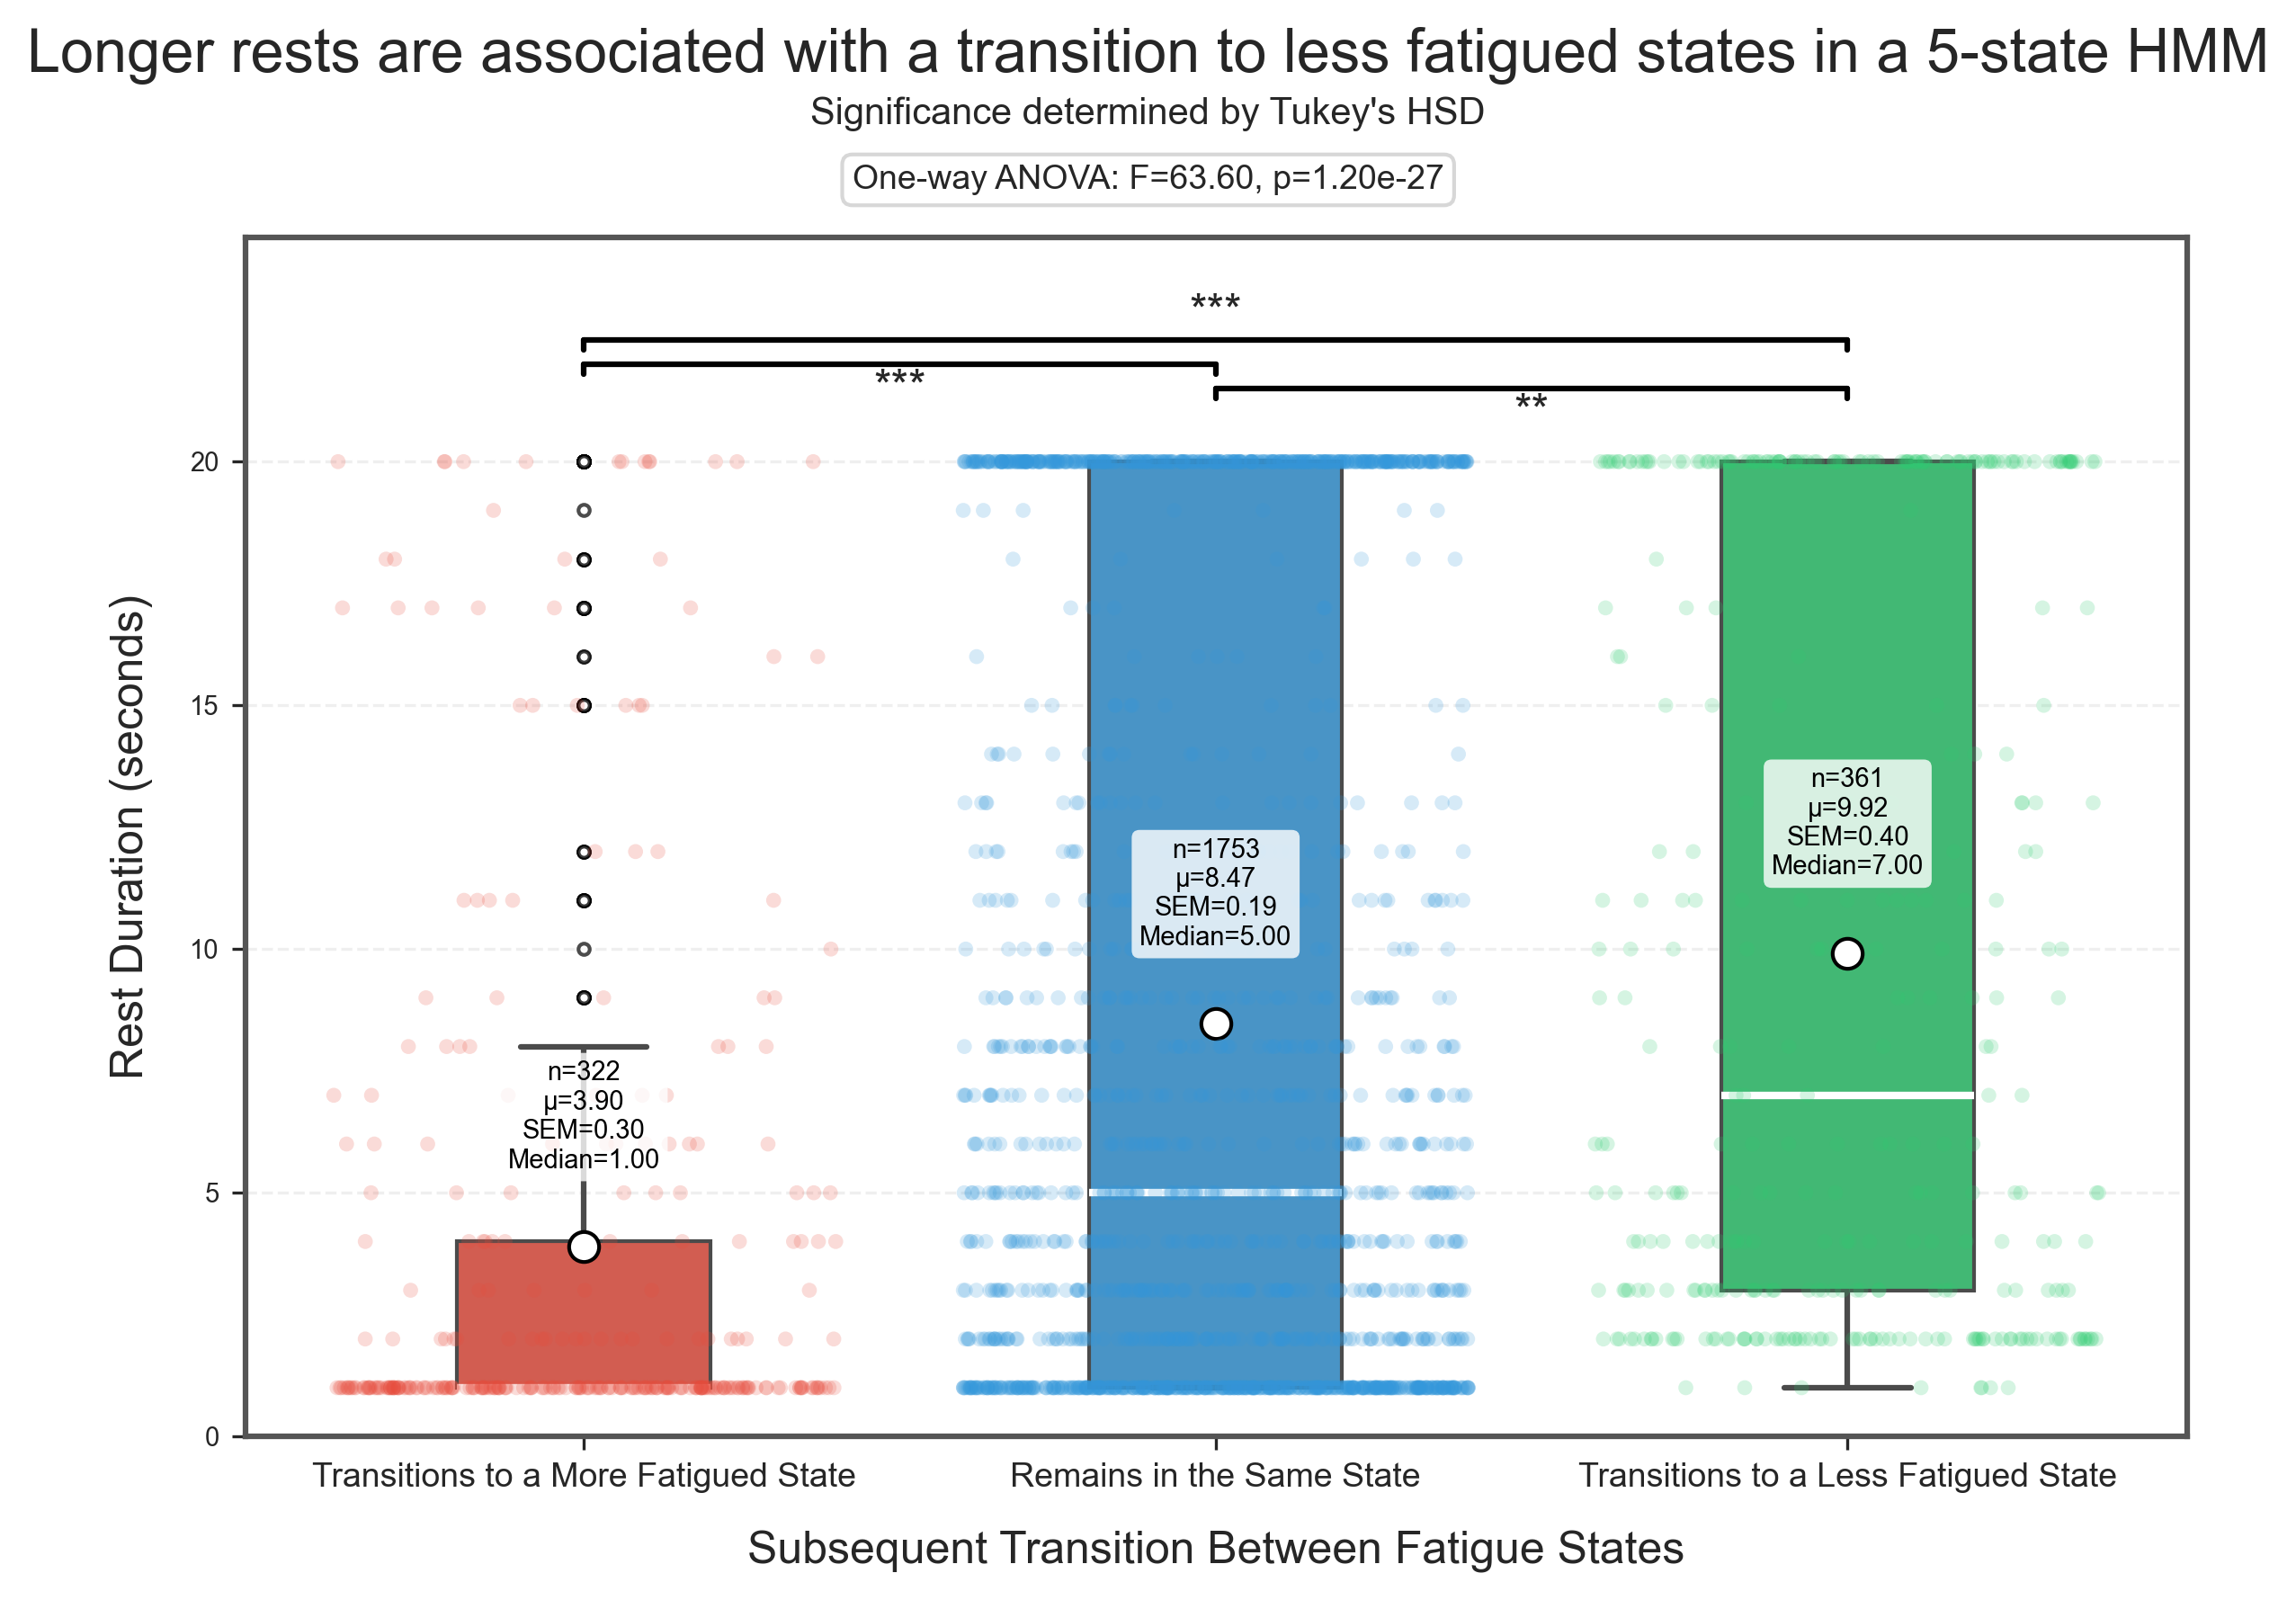

In [30]:
cat_labels = ['Transitions to a More Fatigued State', 'Remains in the Same State', 'Transitions to a Less Fatigued State']
cat_order = [-1,0,1]

# collect rest durations and transitions
rest_recovery = []
for subject_id in test_subjects:
    subj = subject_data[subject_id]
    rest = np.array(subj['post_epoch_post_cue_rest_duration'])
    state_seq = subject_state_sequences[subject_id] # this is now taken from the re-ordered state sequences (from least to most fatigued)

    for t in range(len(rest) - 1):
        from_state = state_seq[t]
        to_state = state_seq[t + 1]
        rest_now = rest[t]

        if to_state < from_state:
            recovery = 1  # transition to less fatigue (recovery)
        elif to_state > from_state:
            recovery = -1 # transition to more fatigue
        else:
            recovery = 0  # same fatigue
        rest_recovery.append({'rest': rest_now, 'recovery': recovery})

rest_recovery_df = pd.DataFrame(rest_recovery)

# Create the mapping in dataframe
rest_recovery_df['recovery_cat'] = pd.Categorical(rest_recovery_df['recovery'], categories=cat_order, ordered=True)
rest_recovery_df['recovery_label'] = rest_recovery_df['recovery_cat'].map(dict(zip(cat_order, cat_labels)))


sns.set_style("ticks")
plt.rcParams.update({
'font.family': 'Arial',
'font.size': 12,
'axes.titlesize': 16,
'axes.labelsize': 14,
'xtick.labelsize': 12,
'ytick.labelsize': 12
})

palette = {
'Transitions to a More Fatigued State': '#E74C3C',
'Remains in the Same State': '#3498DB',
'Transitions to a Less Fatigued State': '#2ECC71'
}

plt.figure(figsize=(8, 6), dpi=300)  # Increased height

sns.set_style("ticks")
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 7
})

# Create boxplots
ax = sns.boxplot(
    x='recovery_label', y='rest', data=rest_recovery_df,
    order=cat_labels, palette=palette, 
    width=0.4, 
    showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":8},
    boxprops={"alpha": 1},
    whiskerprops={"linewidth": 1.5},
    capprops={"linewidth": 1.5},
    medianprops={"color": "white", "linewidth": 2},
    flierprops={"marker":"o", "markerfacecolor":"white", "markersize":3, "markeredgecolor":"black", "alpha":0.7}
)

# Add stripplot with jittered points
sns.stripplot(
    x='recovery_label', y='rest', data=rest_recovery_df,
    order=cat_labels, 
    palette=[palette[cat] for cat in cat_labels],
    size=4, jitter=0.4, alpha=0.2, 
    edgecolor='none',
    ax=ax
)

# Get basic stats
stats_data = []
for cat in cat_labels:
    subset = rest_recovery_df[rest_recovery_df['recovery_label'] == cat]['rest']
    stats_data.append({
        'category': cat,
        'mean': subset.mean(),
        'median': subset.median(),
        'n': len(subset),
        'sem': stats.sem(subset)
    })

stats_df = pd.DataFrame(stats_data)

# Annotate with statistics
for i, row in stats_df.iterrows():
    ax.text(
        i, row['mean'] + 1.5, 
        f"n={row['n']}\nμ={row['mean']:.2f}\nSEM={row['sem']:.2f}\nMedian={row['median']:.2f}", 
        color='black', ha='center', va='bottom', 
        fontsize=7, fontweight='normal',
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3', edgecolor='none')
    )

# Calculate ANOVA
f_val, p_val = stats.f_oneway(
    rest_recovery_df[rest_recovery_df['recovery_label'] == 'Transitions to a More Fatigued State']['rest'],
    rest_recovery_df[rest_recovery_df['recovery_label'] == 'Remains in the Same State']['rest'],
    rest_recovery_df[rest_recovery_df['recovery_label'] == 'Transitions to a Less Fatigued State']['rest']
)

# Format p-value in scientific notation and add ANOVA notation
if p_val < 0.0001:
    # use scientific notation with 2 significant digits
    p_formatted = f"{p_val:.2e}"
else:
    # use regular decimal notation
    p_formatted = f"{p_val:.4f}"

plt.figtext(0.5, 0.88, f"One-way ANOVA: F={f_val:.2f}, p={p_formatted}",
          ha='center', fontsize=9,
          bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.3', edgecolor='lightgrey'))

# do Tukeys HSD to compare between each pair of groups
# Prepare data
groups = []
for cat in cat_labels:
    groups.append(rest_recovery_df[rest_recovery_df['recovery_label'] == cat]['rest'])
# Perform Tukey's HSD test
tukey_results = tukey_hsd(*groups)
# Create a formatted table of pairwise comparisons
pair_labels = []
p_values = []
significances = []
mean_diffs = []

for i in range(len(cat_labels)):
    for j in range(i+1, len(cat_labels)):
        pair_labels.append(f"{cat_labels[i]} vs. {cat_labels[j]}")
        p_val = tukey_results.pvalue[i, j]
        p_values.append(p_val)
        
        # Calculate mean difference
        diff = stats_df.iloc[j]['mean'] - stats_df.iloc[i]['mean']
        mean_diffs.append(diff)
        
        # Add significance stars
        if p_val < 0.001:
            significances.append('***')
        elif p_val < 0.01:
            significances.append('**')
        elif p_val < 0.05:
            significances.append('*')
        else:
            significances.append('ns')

# Create comparison df
comparison_df = pd.DataFrame({
    'Comparison': pair_labels,
    'Mean Difference': mean_diffs,
    'p-value': p_values,
    'Significance': significances
})
# Print results
print("\nTukey's HSD Post-hoc Test Results:")
print(comparison_df)

# Add pairwise comparison annotations to the plot
# Calculate the maximum y value for placing annotations
max_y = rest_recovery_df['rest'].max()
y_pos = max_y + 2  # Position for the first comparison line

# Add significance bars and annotations
bar_height = 0.5  # Height of the significance bars
text_height = 0.1  # Additional height for text

# All possible pairwise comparisons
comparisons = [(0, 1), (1, 2), (0,2)]

for i, (idx1, idx2) in enumerate(comparisons):
    # Get p-value for this comparison
    p_val = tukey_results.pvalue[idx1, idx2]
    
    # Determine significance symbol
    if p_val < 0.001:
        sig_symbol = '***'
    elif p_val < 0.01:
        sig_symbol = '**'
    elif p_val < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = 'ns'
    
    # For the 0-2 comparison 
    if i == 2:  # This is the 0-2 comparison
        # Draw the bar higher
        bar_y = y_pos + bar_height
        # Draw the bar
        ax.plot([idx1, idx2], [bar_y, bar_y], 'k-', linewidth=1.5)
        ax.plot([idx1, idx1], [bar_y - 0.2, bar_y], 'k-', linewidth=1.5)
        ax.plot([idx2, idx2], [bar_y - 0.2, bar_y], 'k-', linewidth=1.5)
        
        # Add the significance symbol above
        ax.text((idx1 + idx2) / 2, bar_y + text_height, 
               sig_symbol, ha='center', va='bottom', fontsize=12)
    else:
        # For 0-1 and 1-2 comparisons
        bar_y = y_pos - (i * bar_height)
        # Draw the bar
        ax.plot([idx1, idx2], [bar_y, bar_y], 'k-', linewidth=1.5)
        ax.plot([idx1, idx1], [bar_y - 0.2, bar_y], 'k-', linewidth=1.5)
        ax.plot([idx2, idx2], [bar_y - 0.2, bar_y], 'k-', linewidth=1.5)
        
        # Add the significance symbol below
        ax.text((idx1 + idx2) / 2, bar_y - text_height, 
               sig_symbol, ha='center', va='top', fontsize=12)

# Adjust y-axis limit to make room for significance bars
ax.set_ylim(0, y_pos + len(comparisons)*bar_height + text_height + 1)


# Set axis labels
ax.set_xlabel('Subsequent Transition Between Fatigue States', labelpad=10)
ax.set_ylabel('Rest Duration (seconds)', labelpad=10)

# Add subtle grid on y-axis
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Customize x-tick labels
plt.xticks(ticks=range(len(cat_labels)), labels=cat_labels)
# y-axis formatting
ax.yaxis.set_major_locator(mtick.MaxNLocator(nbins=6, integer=True))
ax.set_ylim(bottom=0)  # Start y-axis at 0

# Add subtle border
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('#555555')

plt.tight_layout()

# Add main title 
plt.suptitle('Longer rests are associated with a transition to less fatigued states in a 5-state HMM', 
           fontsize=16, y=0.98)

plt.figtext(0.5, 0.92, 'Significance determined by Tukey\'s HSD', 
          ha='center', fontsize=10)

# Adjust the top margin to make room for titles
plt.subplots_adjust(top=0.85)  

plt.savefig('rest_duration_by_fatigue_transition.png', dpi=300, bbox_inches='tight')
plt.savefig('rest_duration_by_fatigue_transition.pdf', bbox_inches='tight')
plt.show()

### used for CCN poster (slightly outdated; shows less sig. because the fatigue states were ordered differently)

In [31]:
subject_state_sequences = {}
for subject_id in test_subjects:
    subj = subject_data[subject_id]
    accuracy = np.array(subj['epoch_accuracy'])
    rest_duration = np.array(subj['post_epoch_post_cue_rest_duration']) / 20
    obs = np.column_stack([accuracy, rest_duration])
    subject_state_sequences[subject_id] = curr_model.predict(obs)

cat_labels = ['Transitions to a More Fatigued State', 'Remains in the Same State', 'Transitions to a Less Fatigued State']
fatigue_order = [0, 1, 2, 4, 3] # 'Focused', 'Slightly Fatigued', 'More Fatigued', 'Extremely Fatigued', 'Given Up'
cat_order = [-1,0,1]

# collect rest durations and transitions
rest_recovery = []
for subject_id in test_subjects:
    subj = subject_data[subject_id]
    rest = np.array(subj['post_epoch_post_cue_rest_duration'])
    state_seq = subject_state_sequences[subject_id]
    for t in range(len(rest) - 1):
        from_state = state_seq[t]
        to_state = state_seq[t + 1]
        rest_now = rest[t]

        if fatigue_order.index(to_state) < fatigue_order.index(from_state):
            recovery = 1  # transition to less fatigue (recovery)
        elif fatigue_order.index(to_state) > fatigue_order.index(from_state):
            recovery = -1 # transition to more fatigue
        else:
            recovery = 0  # same fatigue
        rest_recovery.append({'rest': rest_now, 'recovery': recovery})

rest_recovery_df = pd.DataFrame(rest_recovery)

# save info to the df
print(rest_recovery_df['recovery'].value_counts())
print(rest_recovery_df.groupby('recovery')['rest'].describe())

# plot the recoery states as a block plot
cat_labels = ['Transitions to a More Fatigued State', 'Remains in the Same State', 'Transitions to a Less Fatigued State']
rest_recovery_df['recovery_cat'] = pd.Categorical(rest_recovery_df['recovery'], categories=cat_order, ordered=True)

recovery
 0    1753
 1     355
-1     328
Name: count, dtype: int64
           count      mean       std  min  25%  50%   75%   max
recovery                                                       
-1         328.0  4.493902  5.872756  1.0  1.0  1.0   6.0  20.0
 0        1753.0  8.472333  7.794555  1.0  1.0  5.0  20.0  20.0
 1         355.0  9.467606  7.597646  1.0  2.0  6.0  20.0  20.0


/var/folders/xn/lkw6x82n60l07h4hbhyrhyh40000gn/T/ipykernel_61282/2633734971.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/var/folders/xn/lkw6x82n60l07h4hbhyrhyh40000gn/T/ipykernel_61282/2633734971.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(



Tukey's HSD Post-hoc Test Results:
                                          Comparison  Mean Difference  \
0  Transitions to a More Fatigued State vs. Remai...         3.978431   
1  Transitions to a More Fatigued State vs. Trans...         4.973703   
2  Remains in the Same State vs. Transitions to a...         0.995272   

    p-value Significance  
0  0.000000          ***  
1  0.000000          ***  
2  0.060373           ns  


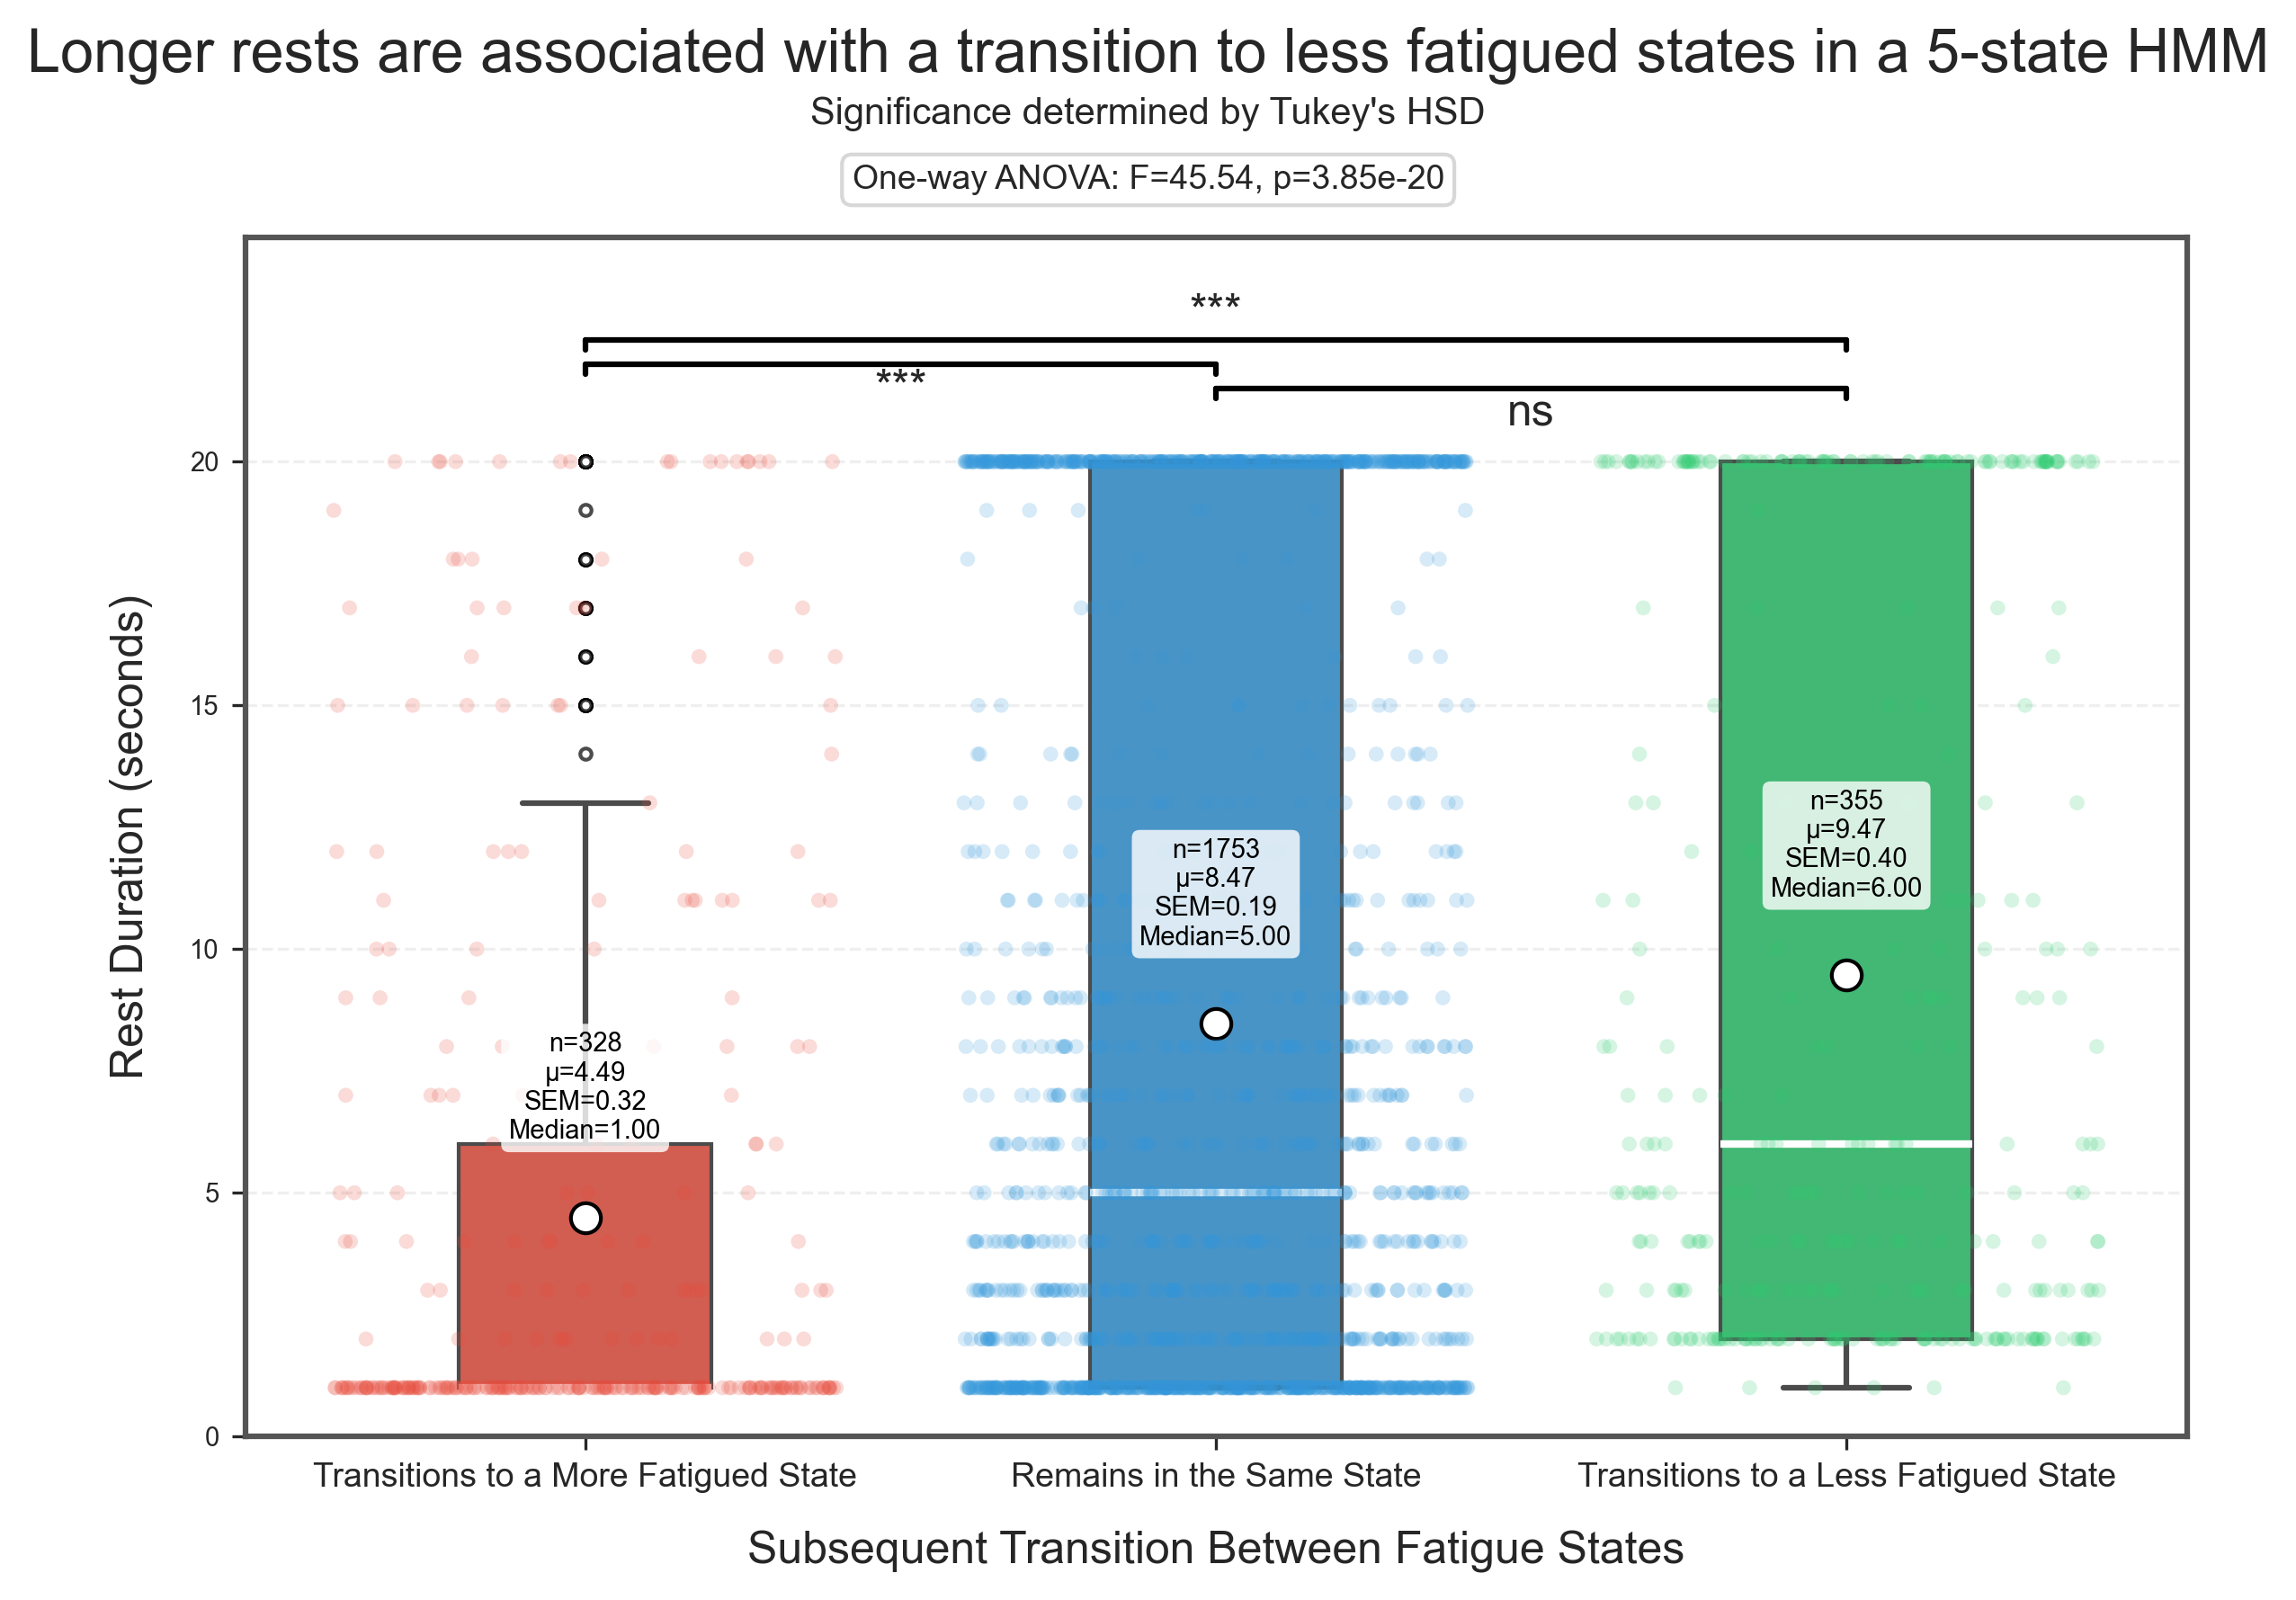

In [32]:
#USED FOR CCN
cat_labels = ['Transitions to a More Fatigued State', 'Remains in the Same State', 'Transitions to a Less Fatigued State']
fatigue_order = [0, 1, 2, 4, 3] # 'Focused', 'Slightly Fatigued', 'More Fatigued', 'Extremely Fatigued', 'Given Up'
cat_order = [-1,0,1]
# collect rest durations and transitions
rest_recovery = []
for subject_id in test_subjects:
    subj = subject_data[subject_id]
    rest = np.array(subj['post_epoch_post_cue_rest_duration'])
    state_seq = subject_state_sequences[subject_id]
    for t in range(len(rest) - 1):
        from_state = state_seq[t]
        to_state = state_seq[t + 1]
        rest_now = rest[t]

        if fatigue_order.index(to_state) < fatigue_order.index(from_state):
            recovery = 1  # transition to less fatigue (recovery)
        elif fatigue_order.index(to_state) > fatigue_order.index(from_state):
            recovery = -1 # transition to more fatigue
        else:
            recovery = 0  # same fatigue
        rest_recovery.append({'rest': rest_now, 'recovery': recovery})

rest_recovery_df = pd.DataFrame(rest_recovery)

# Create the mapping in dataframe
rest_recovery_df['recovery_cat'] = pd.Categorical(rest_recovery_df['recovery'], categories=cat_order, ordered=True)
rest_recovery_df['recovery_label'] = rest_recovery_df['recovery_cat'].map(dict(zip(cat_order, cat_labels)))


sns.set_style("ticks")
plt.rcParams.update({
'font.family': 'Arial',
'font.size': 12,
'axes.titlesize': 16,
'axes.labelsize': 14,
'xtick.labelsize': 12,
'ytick.labelsize': 12
})

palette = {
'Transitions to a More Fatigued State': '#E74C3C',
'Remains in the Same State': '#3498DB',
'Transitions to a Less Fatigued State': '#2ECC71'
}

plt.figure(figsize=(8, 6), dpi=300)  # Increased height

sns.set_style("ticks")
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 7
})

# Create boxplots
ax = sns.boxplot(
    x='recovery_label', y='rest', data=rest_recovery_df,
    order=cat_labels, palette=palette, 
    width=0.4, 
    showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":8},
    boxprops={"alpha": 1},
    whiskerprops={"linewidth": 1.5},
    capprops={"linewidth": 1.5},
    medianprops={"color": "white", "linewidth": 2},
    flierprops={"marker":"o", "markerfacecolor":"white", "markersize":3, "markeredgecolor":"black", "alpha":0.7}
)

# Add stripplot with jittered points
sns.stripplot(
    x='recovery_label', y='rest', data=rest_recovery_df,
    order=cat_labels, 
    palette=[palette[cat] for cat in cat_labels],
    size=4, jitter=0.4, alpha=0.2, 
    edgecolor='none',
    ax=ax
)

# Get basic stats
stats_data = []
for cat in cat_labels:
    subset = rest_recovery_df[rest_recovery_df['recovery_label'] == cat]['rest']
    stats_data.append({
        'category': cat,
        'mean': subset.mean(),
        'median': subset.median(),
        'n': len(subset),
        'sem': stats.sem(subset)
    })

stats_df = pd.DataFrame(stats_data)

# Annotate with statistics
for i, row in stats_df.iterrows():
    ax.text(
        i, row['mean'] + 1.5, 
        f"n={row['n']}\nμ={row['mean']:.2f}\nSEM={row['sem']:.2f}\nMedian={row['median']:.2f}", 
        color='black', ha='center', va='bottom', 
        fontsize=7, fontweight='normal',
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3', edgecolor='none')
    )

# Calculate ANOVA
f_val, p_val = stats.f_oneway(
    rest_recovery_df[rest_recovery_df['recovery_label'] == 'Transitions to a More Fatigued State']['rest'],
    rest_recovery_df[rest_recovery_df['recovery_label'] == 'Remains in the Same State']['rest'],
    rest_recovery_df[rest_recovery_df['recovery_label'] == 'Transitions to a Less Fatigued State']['rest']
)

# Format p-value in scientific notation and add ANOVA notation
if p_val < 0.0001:
    # use scientific notation with 2 significant digits
    p_formatted = f"{p_val:.2e}"
else:
    # use regular decimal notation
    p_formatted = f"{p_val:.4f}"

plt.figtext(0.5, 0.88, f"One-way ANOVA: F={f_val:.2f}, p={p_formatted}",
          ha='center', fontsize=9,
          bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.3', edgecolor='lightgrey'))

# do Tukeys HSD to compare between each pair of groups
# Prepare data
groups = []
for cat in cat_labels:
    groups.append(rest_recovery_df[rest_recovery_df['recovery_label'] == cat]['rest'])
# Perform Tukey's HSD test
tukey_results = tukey_hsd(*groups)
# Create a formatted table of pairwise comparisons
pair_labels = []
p_values = []
significances = []
mean_diffs = []

for i in range(len(cat_labels)):
    for j in range(i+1, len(cat_labels)):
        pair_labels.append(f"{cat_labels[i]} vs. {cat_labels[j]}")
        p_val = tukey_results.pvalue[i, j]
        p_values.append(p_val)
        
        # Calculate mean difference
        diff = stats_df.iloc[j]['mean'] - stats_df.iloc[i]['mean']
        mean_diffs.append(diff)
        
        # Add significance stars
        if p_val < 0.001:
            significances.append('***')
        elif p_val < 0.01:
            significances.append('**')
        elif p_val < 0.05:
            significances.append('*')
        else:
            significances.append('ns')

# Create comparison df
comparison_df = pd.DataFrame({
    'Comparison': pair_labels,
    'Mean Difference': mean_diffs,
    'p-value': p_values,
    'Significance': significances
})
# Print results
print("\nTukey's HSD Post-hoc Test Results:")
print(comparison_df)

# Add pairwise comparison annotations to the plot
# Calculate the maximum y value for placing annotations
max_y = rest_recovery_df['rest'].max()
y_pos = max_y + 2  # Position for the first comparison line

# Add significance bars and annotations
bar_height = 0.5  # Height of the significance bars
text_height = 0.1  # Additional height for text

# All possible pairwise comparisons
comparisons = [(0, 1), (1, 2), (0,2)]

for i, (idx1, idx2) in enumerate(comparisons):
    # Get p-value for this comparison
    p_val = tukey_results.pvalue[idx1, idx2]
    
    # Determine significance symbol
    if p_val < 0.001:
        sig_symbol = '***'
    elif p_val < 0.01:
        sig_symbol = '**'
    elif p_val < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = 'ns'
    
    # For the 0-2 comparison 
    if i == 2:  # This is the 0-2 comparison
        # Draw the bar higher
        bar_y = y_pos + bar_height
        # Draw the bar
        ax.plot([idx1, idx2], [bar_y, bar_y], 'k-', linewidth=1.5)
        ax.plot([idx1, idx1], [bar_y - 0.2, bar_y], 'k-', linewidth=1.5)
        ax.plot([idx2, idx2], [bar_y - 0.2, bar_y], 'k-', linewidth=1.5)
        
        # Add the significance symbol above
        ax.text((idx1 + idx2) / 2, bar_y + text_height, 
               sig_symbol, ha='center', va='bottom', fontsize=12)
    else:
        # For 0-1 and 1-2 comparisons
        bar_y = y_pos - (i * bar_height)
        # Draw the bar
        ax.plot([idx1, idx2], [bar_y, bar_y], 'k-', linewidth=1.5)
        ax.plot([idx1, idx1], [bar_y - 0.2, bar_y], 'k-', linewidth=1.5)
        ax.plot([idx2, idx2], [bar_y - 0.2, bar_y], 'k-', linewidth=1.5)
        
        # Add the significance symbol below
        ax.text((idx1 + idx2) / 2, bar_y - text_height, 
               sig_symbol, ha='center', va='top', fontsize=12)

# Adjust y-axis limit to make room for significance bars
ax.set_ylim(0, y_pos + len(comparisons)*bar_height + text_height + 1)


# Set axis labels
ax.set_xlabel('Subsequent Transition Between Fatigue States', labelpad=10)
ax.set_ylabel('Rest Duration (seconds)', labelpad=10)

# Add subtle grid on y-axis
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Customize x-tick labels
plt.xticks(ticks=range(len(cat_labels)), labels=cat_labels)
# y-axis formatting
ax.yaxis.set_major_locator(mtick.MaxNLocator(nbins=6, integer=True))
ax.set_ylim(bottom=0)  # Start y-axis at 0

# Add subtle border
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('#555555')

plt.tight_layout()

# Add main title 
plt.suptitle('Longer rests are associated with a transition to less fatigued states in a 5-state HMM', 
           fontsize=16, y=0.98)

plt.figtext(0.5, 0.92, 'Significance determined by Tukey\'s HSD', 
          ha='center', fontsize=10)

# Adjust the top margin to make room for titles
plt.subplots_adjust(top=0.85)  

plt.savefig('rest_duration_by_fatigue_transition.png', dpi=300, bbox_inches='tight')
plt.savefig('rest_duration_by_fatigue_transition.pdf', bbox_inches='tight')
plt.show()

In [29]:
rest_recovery_df

,rest,recovery,recovery_cat,recovery_label
0,3,0,0,Remains in the Same State
1,2,0,0,Remains in the Same State
2,4,0,0,Remains in the Same State
3,2,0,0,Remains in the Same State
4,2,0,0,Remains in the Same State
...,...,...,...,...
2431,2,0,0,Remains in the Same State
2432,10,0,0,Remains in the Same State
2433,3,0,0,Remains in the Same State
2434,3,1,1,Transitions to a Less Fatigued State


# analysis that applies to all models:


TASK SWITCHING ANALYSIS: 3-STATE MODEL

Transition counts:
  Switch transitions: 588
  Stay transitions: 1764

1. STATE DISTRIBUTION ANALYSIS
----------------------------------------
Overall state distribution:
  State 0: 1131 (44.9%)
  State 1: 781 (31.0%)
  State 2: 608 (24.1%)

State distribution after SWITCH:
  State 0: 257 (43.7%)
  State 1: 193 (32.8%)
  State 2: 138 (23.5%)

State distribution after STAY:
  State 0: 780 (44.2%)
  State 1: 567 (32.1%)
  State 2: 417 (23.6%)

2. TRANSITION MATRIX ANALYSIS
----------------------------------------
Switch transition matrix:
[[0.74712644 0.17241379 0.08045977]
 [0.20526316 0.75789474 0.03684211]
 [0.16788321 0.02919708 0.80291971]]

Stay transition matrix:
[[0.77877238 0.13938619 0.08184143]
 [0.17117117 0.79459459 0.03423423]
 [0.17798595 0.03981265 0.78220141]]

3. FATIGUE RECOVERY ANALYSIS
----------------------------------------

Switch transitions:
  Recovery: 66 (11.2%)
  Same fatigue: 449 (76.4%)
  Worse fatigue: 73 (12.4%)

S

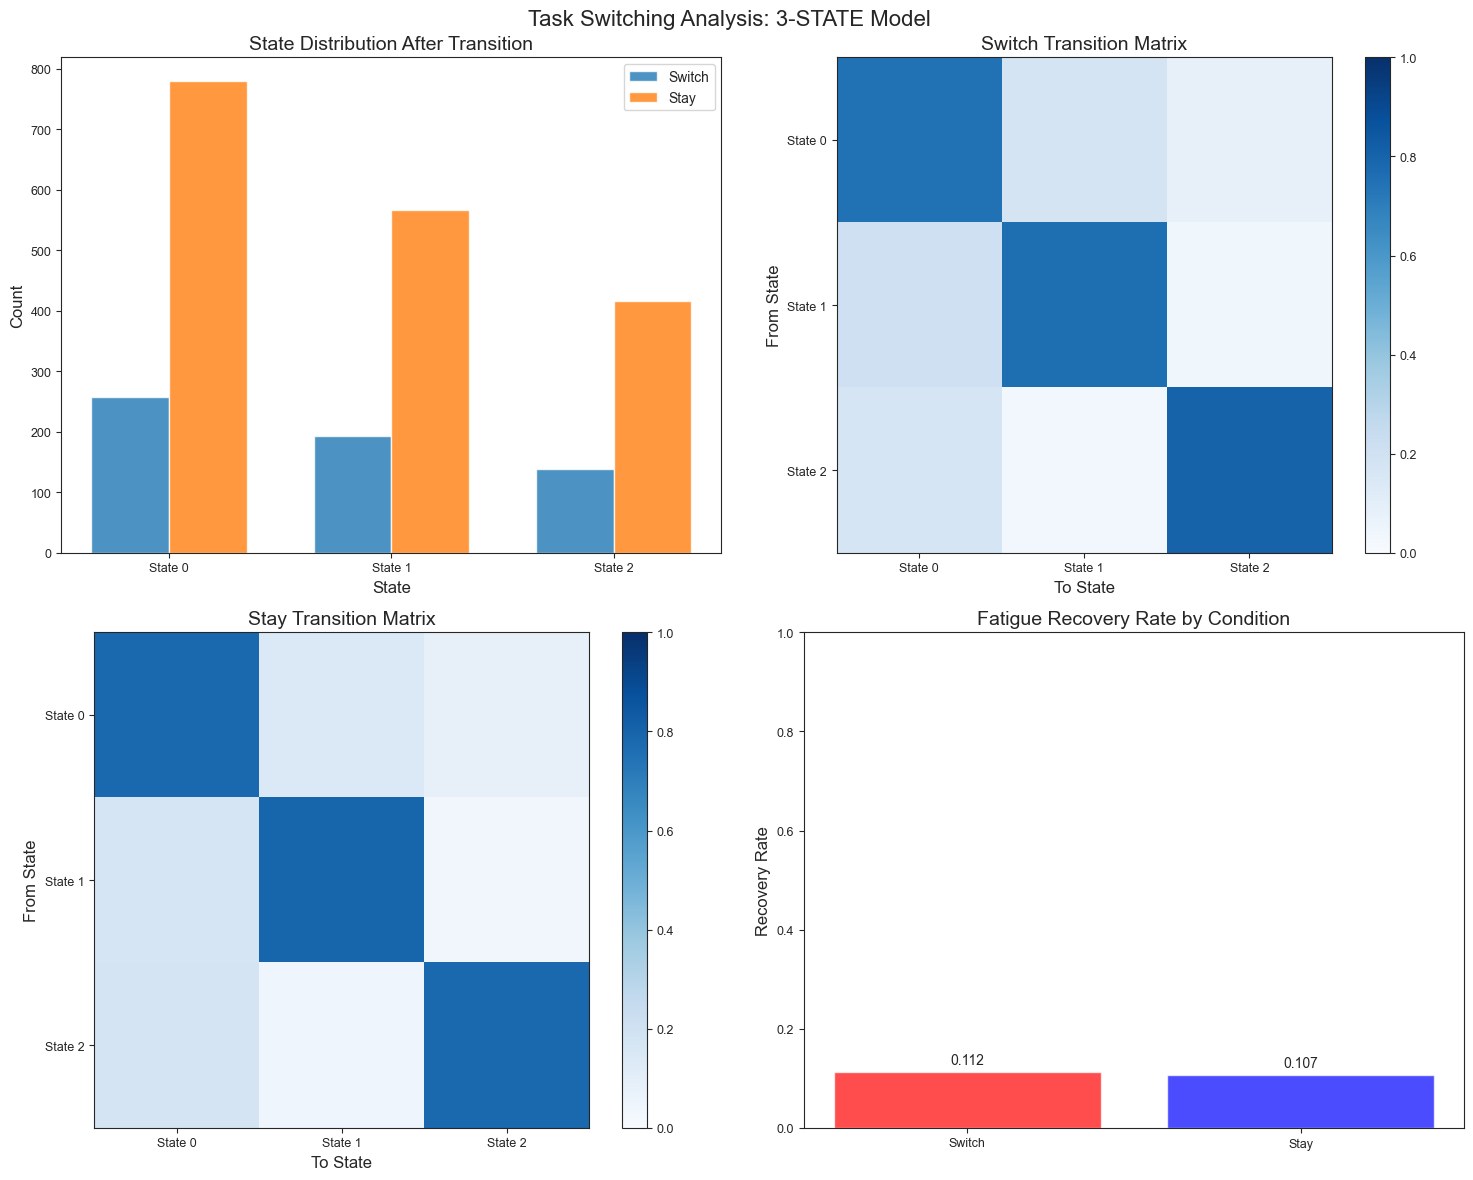


5. STATISTICAL TESTS
----------------------------------------
Chi-square test for state distribution:
  Chi2 = 0.095, p = 0.9538
  Degrees of freedom = 2
  No significant difference in state distribution between switch and stay conditions.

Z-test for recovery rate difference:
  Z = 0.384, p = 0.7013
  No significant difference in recovery rate between switch and stay conditions.

END OF 3-STATE MODEL ANALYSIS


TASK SWITCHING ANALYSIS: 5-STATE MODEL

Transition counts:
  Switch transitions: 588
  Stay transitions: 1764

1. STATE DISTRIBUTION ANALYSIS
----------------------------------------
Overall state distribution:
  State 0: 672 (26.7%)
  State 1: 469 (18.6%)
  State 2: 237 (9.4%)
  State 3: 594 (23.6%)
  State 4: 548 (21.7%)

State distribution after SWITCH:
  State 0: 170 (28.9%)
  State 1: 101 (17.2%)
  State 2: 53 (9.0%)
  State 3: 137 (23.3%)
  State 4: 127 (21.6%)

State distribution after STAY:
  State 0: 489 (27.7%)
  State 1: 325 (18.4%)
  State 2: 168 (9.5%)
  State 3: 

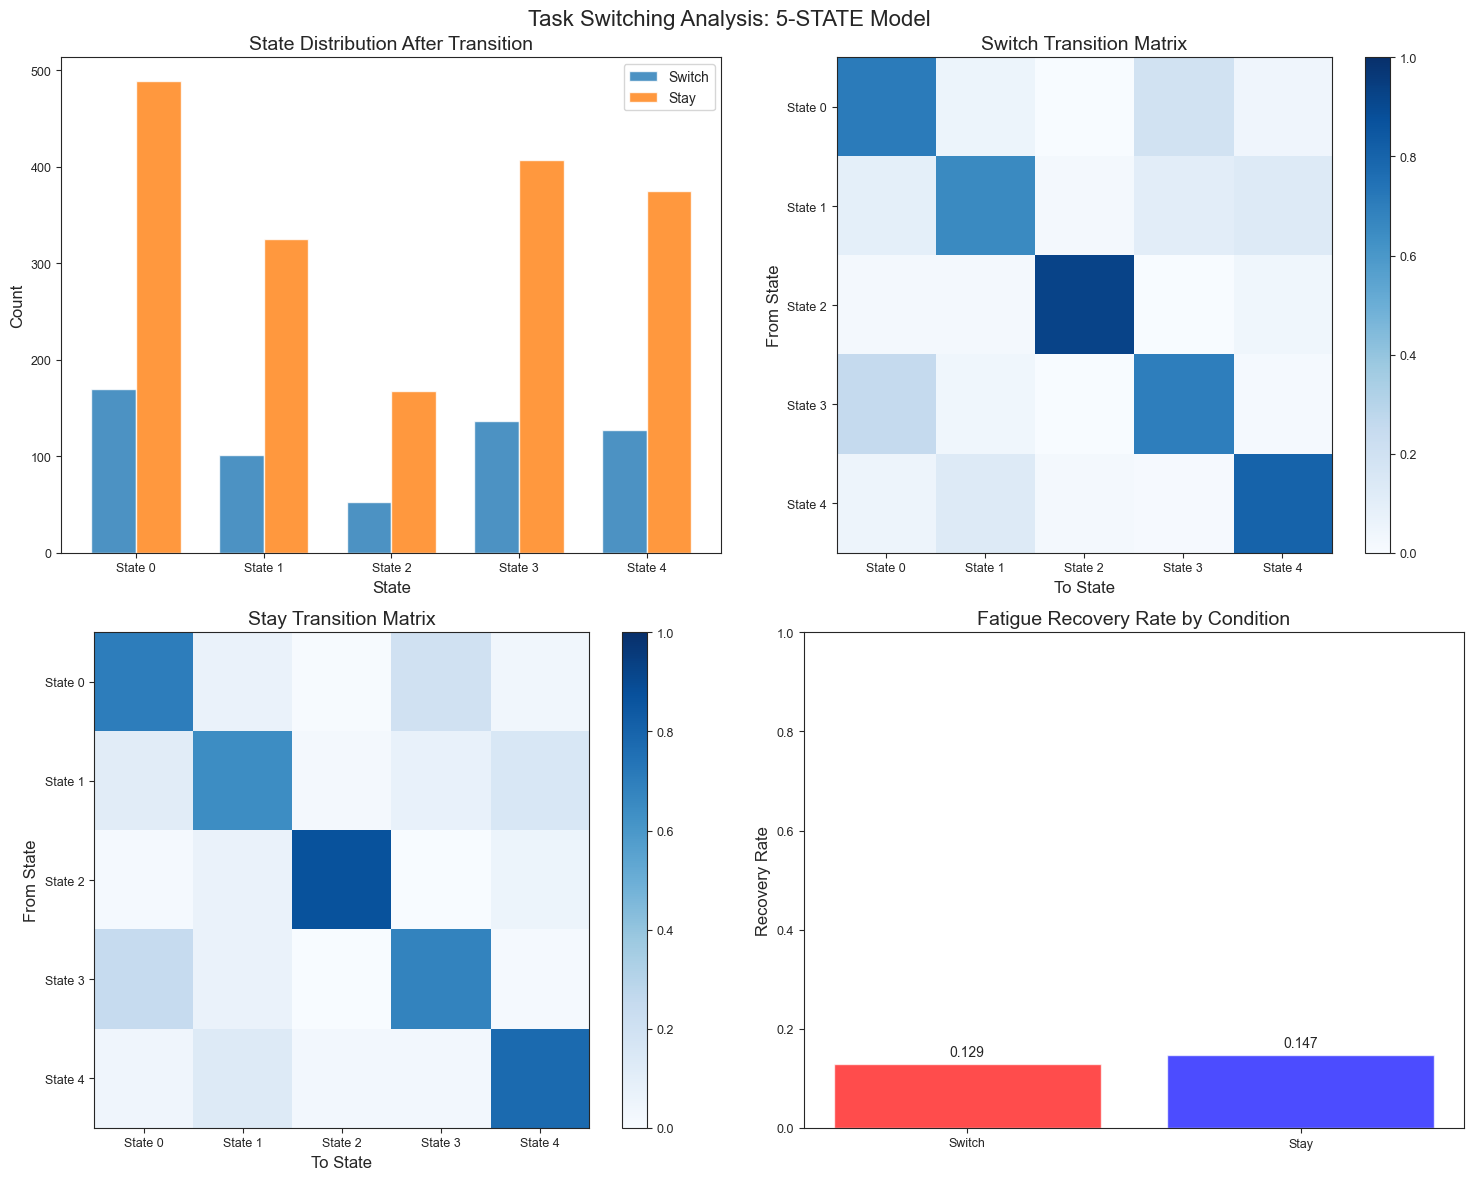


5. STATISTICAL TESTS
----------------------------------------
Chi-square test for state distribution:
  Chi2 = 0.758, p = 0.9440
  Degrees of freedom = 4
  No significant difference in state distribution between switch and stay conditions.

Z-test for recovery rate difference:
  Z = -1.056, p = 0.2910
  No significant difference in recovery rate between switch and stay conditions.

END OF 5-STATE MODEL ANALYSIS



In [20]:
# Task Switching Analysis
# =====================

# Choose models to analyze
models_to_analyze = ['3-state', '5-state']

for model_name in models_to_analyze:
    print(f"\n{'='*60}")
    print(f"TASK SWITCHING ANALYSIS: {model_name.upper()} MODEL")
    print(f"{'='*60}")
    
    # Get the model
    curr_model = models_data[model_name]['model']
    n_states = curr_model.n_components
    
    # Predict states for all subjects
    subject_state_sequences = {}
    for subject_id in test_subjects:
        subj = subject_data[subject_id]
        accuracy = np.array(subj['epoch_accuracy'])
        rest_duration = np.array(subj['post_epoch_post_cue_rest_duration']) / 20
        obs = np.column_stack([accuracy, rest_duration])
        state_seq = curr_model.predict(obs)
        subject_state_sequences[subject_id] = state_seq
    
    # Collect transition data with switch information
    switch_transitions = []
    stay_transitions = []
    
    for subject_id in test_subjects:
        subj = subject_data[subject_id]
        state_seq = subject_state_sequences[subject_id]
        switch_info = subj['epoch_follows_task_switch']
        
        for t in range(len(state_seq) - 1):
            from_state = state_seq[t]
            to_state = state_seq[t + 1]
            
            # Skip first epoch (no switch info)
            if t == 0:
                continue
                
            transition = {
                'subject': subject_id,
                'epoch': t + 1,
                'from_state': from_state,
                'to_state': to_state,
                'is_switch': switch_info[t] == 1
            }
            
            if switch_info[t] == 1:  # Switch
                switch_transitions.append(transition)
            else:  # Stay
                stay_transitions.append(transition)
    
    # Convert to DataFrames
    switch_df = pd.DataFrame(switch_transitions)
    stay_df = pd.DataFrame(stay_transitions)
    
    print(f"\nTransition counts:")
    print(f"  Switch transitions: {len(switch_df)}")
    print(f"  Stay transitions: {len(stay_df)}")
    
    # 1. State distribution analysis
    print(f"\n1. STATE DISTRIBUTION ANALYSIS")
    print(f"{'-'*40}")
    
    # Overall state distribution
    all_states = []
    for seq in subject_state_sequences.values():
        all_states.extend(seq)
    
    state_counts = np.bincount(all_states, minlength=n_states)
    print(f"Overall state distribution:")
    for i, count in enumerate(state_counts):
        print(f"  State {i}: {count} ({count/len(all_states)*100:.1f}%)")
    
    # State distribution by switch condition
    if len(switch_df) > 0:
        switch_states = switch_df['to_state'].value_counts().sort_index()
        print(f"\nState distribution after SWITCH:")
        for state in range(n_states):
            count = switch_states.get(state, 0)
            print(f"  State {state}: {count} ({count/len(switch_df)*100:.1f}%)")
    
    if len(stay_df) > 0:
        stay_states = stay_df['to_state'].value_counts().sort_index()
        print(f"\nState distribution after STAY:")
        for state in range(n_states):
            count = stay_states.get(state, 0)
            print(f"  State {state}: {count} ({count/len(stay_df)*100:.1f}%)")
    
    # 2. Transition matrix analysis
    print(f"\n2. TRANSITION MATRIX ANALYSIS")
    print(f"{'-'*40}")
    
    # Create transition matrices
    def create_transition_matrix(transitions_df):
        if len(transitions_df) == 0:
            return np.zeros((n_states, n_states))
        
        trans_matrix = np.zeros((n_states, n_states))
        for _, row in transitions_df.iterrows():
            from_state = int(row['from_state'])
            to_state = int(row['to_state'])
            trans_matrix[from_state, to_state] += 1
        
        # Normalize to probabilities
        row_sums = trans_matrix.sum(axis=1)
        row_sums[row_sums == 0] = 1
        trans_matrix = trans_matrix / row_sums[:, np.newaxis]
        
        return trans_matrix
    
    switch_trans_matrix = create_transition_matrix(switch_df)
    stay_trans_matrix = create_transition_matrix(stay_df)
    
    print(f"Switch transition matrix:")
    print(switch_trans_matrix)
    print(f"\nStay transition matrix:")
    print(stay_trans_matrix)
    
    # 3. Fatigue recovery analysis
    print(f"\n3. FATIGUE RECOVERY ANALYSIS")
    print(f"{'-'*40}")
    
    # Define fatigue order (least to most fatigued)
    if model_name == '3-state':
        fatigue_order = [0, 1, 2]
    elif model_name == '5-state':
        fatigue_order = [0, 1, 2, 4, 3]
    
    def analyze_recovery(transitions_df, condition_name):
        if len(transitions_df) == 0:
            return
        
        recovery_counts = {'recovery': 0, 'same': 0, 'worse': 0}
        
        for _, row in transitions_df.iterrows():
            from_state = int(row['from_state'])
            to_state = int(row['to_state'])
            
            from_fatigue = fatigue_order.index(from_state)
            to_fatigue = fatigue_order.index(to_state)
            
            if to_fatigue < from_fatigue:
                recovery_counts['recovery'] += 1
            elif to_fatigue == from_fatigue:
                recovery_counts['same'] += 1
            else:
                recovery_counts['worse'] += 1
        
        total = len(transitions_df)
        print(f"\n{condition_name} transitions:")
        print(f"  Recovery: {recovery_counts['recovery']} ({recovery_counts['recovery']/total*100:.1f}%)")
        print(f"  Same fatigue: {recovery_counts['same']} ({recovery_counts['same']/total*100:.1f}%)")
        print(f"  Worse fatigue: {recovery_counts['worse']} ({recovery_counts['worse']/total*100:.1f}%)")
    
    analyze_recovery(switch_df, "Switch")
    analyze_recovery(stay_df, "Stay")
    
    # 4. Visualizations
    print(f"\n4. VISUALIZATIONS")
    print(f"{'-'*40}")
    
    # Create subplots for visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Task Switching Analysis: {model_name.upper()} Model', fontsize=16)
    
    # Plot 1: State distribution comparison
    ax1 = axes[0, 0]
    if len(switch_df) > 0 and len(stay_df) > 0:
        switch_states = switch_df['to_state'].value_counts().sort_index()
        stay_states = stay_df['to_state'].value_counts().sort_index()
        
        x = np.arange(n_states)
        width = 0.35
        
        switch_counts = [switch_states.get(i, 0) for i in range(n_states)]
        stay_counts = [stay_states.get(i, 0) for i in range(n_states)]
        
        ax1.bar(x - width/2, switch_counts, width, label='Switch', alpha=0.8)
        ax1.bar(x + width/2, stay_counts, width, label='Stay', alpha=0.8)
        ax1.set_xlabel('State')
        ax1.set_ylabel('Count')
        ax1.set_title('State Distribution After Transition')
        ax1.set_xticks(x)
        ax1.set_xticklabels([f'State {i}' for i in range(n_states)])
        ax1.legend()
    
    # Plot 2: Transition matrices heatmap
    ax2 = axes[0, 1]
    if len(switch_df) > 0:
        im = ax2.imshow(switch_trans_matrix, cmap='Blues', vmin=0, vmax=1)
        ax2.set_title('Switch Transition Matrix')
        ax2.set_xlabel('To State')
        ax2.set_ylabel('From State')
        ax2.set_xticks(range(n_states))
        ax2.set_yticks(range(n_states))
        ax2.set_xticklabels([f'State {i}' for i in range(n_states)])
        ax2.set_yticklabels([f'State {i}' for i in range(n_states)])
        plt.colorbar(im, ax=ax2)
    
    # Plot 3: Stay transition matrix
    ax3 = axes[1, 0]
    if len(stay_df) > 0:
        im = ax3.imshow(stay_trans_matrix, cmap='Blues', vmin=0, vmax=1)
        ax3.set_title('Stay Transition Matrix')
        ax3.set_xlabel('To State')
        ax3.set_ylabel('From State')
        ax3.set_xticks(range(n_states))
        ax3.set_yticks(range(n_states))
        ax3.set_xticklabels([f'State {i}' for i in range(n_states)])
        ax3.set_yticklabels([f'State {i}' for i in range(n_states)])
        plt.colorbar(im, ax=ax3)
    
    # Plot 4: Recovery comparison
    ax4 = axes[1, 1]
    if len(switch_df) > 0 and len(stay_df) > 0:
        # Calculate recovery rates
        def get_recovery_rate(transitions_df):
            if len(transitions_df) == 0:
                return 0
            
            recovery_count = 0
            for _, row in transitions_df.iterrows():
                from_state = int(row['from_state'])
                to_state = int(row['to_state'])
                
                from_fatigue = fatigue_order.index(from_state)
                to_fatigue = fatigue_order.index(to_state)
                
                if to_fatigue < from_fatigue:
                    recovery_count += 1
            
            return recovery_count / len(transitions_df)
        
        switch_recovery_rate = get_recovery_rate(switch_df)
        stay_recovery_rate = get_recovery_rate(stay_df)
        
        conditions = ['Switch', 'Stay']
        recovery_rates = [switch_recovery_rate, stay_recovery_rate]
        
        bars = ax4.bar(conditions, recovery_rates, color=['red', 'blue'], alpha=0.7)
        ax4.set_ylabel('Recovery Rate')
        ax4.set_title('Fatigue Recovery Rate by Condition')
        ax4.set_ylim(0, 1)
        
        # Add value labels on bars
        for bar, rate in zip(bars, recovery_rates):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{rate:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # 5. Statistical tests
    print(f"\n5. STATISTICAL TESTS")
    print(f"{'-'*40}")
    
    if len(switch_df) > 0 and len(stay_df) > 0:
        # Chi-square test for state distribution
        from scipy.stats import chi2_contingency
        
        # Create contingency table
        switch_states = switch_df['to_state'].value_counts().sort_index()
        stay_states = stay_df['to_state'].value_counts().sort_index()
        
        # Ensure all states are represented
        all_states = set(range(n_states))
        switch_counts = [switch_states.get(state, 0) for state in all_states]
        stay_counts = [stay_states.get(state, 0) for state in all_states]
        
        contingency_table = np.array([switch_counts, stay_counts])
        
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        print(f"Chi-square test for state distribution:")
        print(f"  Chi2 = {chi2:.3f}, p = {p_value:.4f}")
        print(f"  Degrees of freedom = {dof}")
        
        if p_value < 0.05:
            print(f"  Significant difference in state distribution between switch and stay conditions!")
        else:
            print(f"  No significant difference in state distribution between switch and stay conditions.")
        
        # Test for recovery rate difference
        from scipy.stats import norm        
        def get_recovery_count(transitions_df):
            if len(transitions_df) == 0:
                return 0
            
            recovery_count = 0
            for _, row in transitions_df.iterrows():
                from_state = int(row['from_state'])
                to_state = int(row['to_state'])
                
                from_fatigue = fatigue_order.index(from_state)
                to_fatigue = fatigue_order.index(to_state)
                
                if to_fatigue < from_fatigue:
                    recovery_count += 1
            
            return recovery_count
        
        switch_recovery_count = get_recovery_count(switch_df)
        stay_recovery_count = get_recovery_count(stay_df)
        
        switch_total = len(switch_df)
        stay_total = len(stay_df)
        
        # Manual z-test for proportions
        if switch_total > 0 and stay_total > 0:
            p1 = switch_recovery_count / switch_total
            p2 = stay_recovery_count / stay_total
            
            # Pooled proportion
            pooled_p = (switch_recovery_count + stay_recovery_count) / (switch_total + stay_total)
            
            # Standard error
            se = np.sqrt(pooled_p * (1 - pooled_p) * (1/switch_total + 1/stay_total))
            
            # Z-statistic
            z_stat = (p1 - p2) / se
            
            # P-value (two-tailed)
            p_value = 2 * (1 - norm.cdf(abs(z_stat)))
        else:
            z_stat = 0
            p_value = 1.0
        
        print(f"\nZ-test for recovery rate difference:")
        print(f"  Z = {z_stat:.3f}, p = {p_value:.4f}")
        
        if p_value < 0.05:
            print(f"  Significant difference in recovery rate between switch and stay conditions!")
        else:
            print(f"  No significant difference in recovery rate between switch and stay conditions.")
    
    print(f"\n{'='*60}")
    print(f"END OF {model_name.upper()} MODEL ANALYSIS")
    print(f"{'='*60}\n")

INTERACTION ANALYSIS: Previous Performance × Task Switching

3-STATE MODEL:
----------------------------------------
Total transitions analyzed: 2352

1. DESCRIPTIVE ANALYSIS BY CONDITION
----------------------------------------
High Performance + Switch:
  N = 385, Recovery rate = 0.135, Worse rate = 0.117, Mean fatigue change = -0.023
High Performance + Stay:
  N = 1191, Recovery rate = 0.126, Worse rate = 0.102, Mean fatigue change = -0.039
Medium Performance + Switch:
  N = 86, Recovery rate = 0.047, Worse rate = 0.163, Mean fatigue change = 0.105
Medium Performance + Stay:
  N = 233, Recovery rate = 0.056, Worse rate = 0.155, Mean fatigue change = 0.112
Low Performance + Switch:
  N = 117, Recovery rate = 0.085, Worse rate = 0.120, Mean fatigue change = 0.043
Low Performance + Stay:
  N = 340, Recovery rate = 0.074, Worse rate = 0.103, Mean fatigue change = 0.038

2. STATISTICAL ANALYSIS
----------------------------------------
Chi-square test for Performance × Switch × Recovery i

/var/folders/xn/lkw6x82n60l07h4hbhyrhyh40000gn/T/ipykernel_49238/4035452622.py:258: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


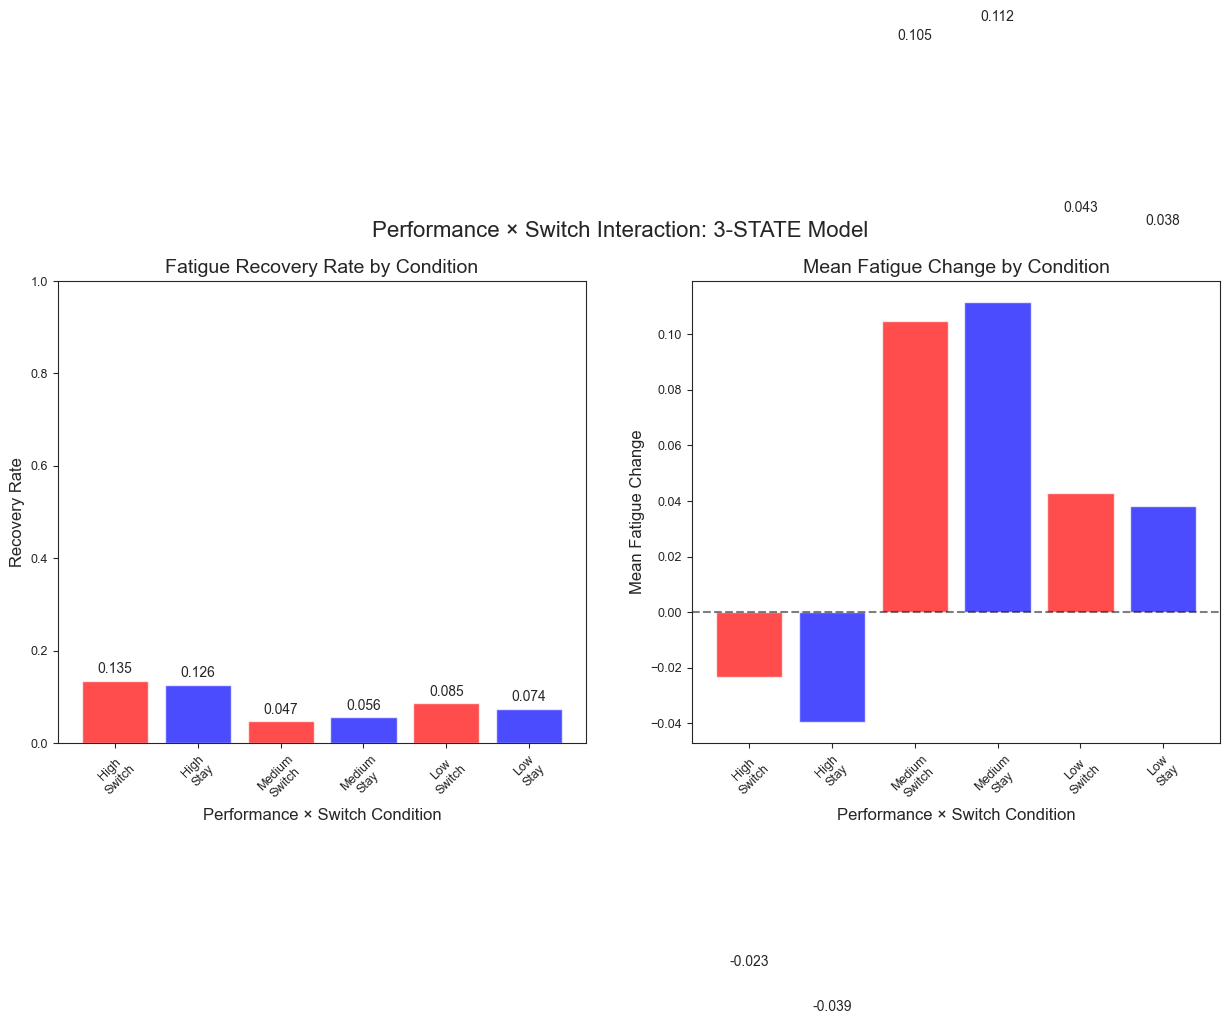


5. SUMMARY OF FINDINGS
----------------------------------------
High performance + Switch recovery rate: 0.135
High performance + Stay recovery rate: 0.126

END OF 3-STATE MODEL INTERACTION ANALYSIS


5-STATE MODEL:
----------------------------------------
Total transitions analyzed: 2352

1. DESCRIPTIVE ANALYSIS BY CONDITION
----------------------------------------
High Performance + Switch:
  N = 385, Recovery rate = 0.145, Worse rate = 0.140, Mean fatigue change = -0.026
High Performance + Stay:
  N = 1191, Recovery rate = 0.160, Worse rate = 0.144, Mean fatigue change = -0.064
Medium Performance + Switch:
  N = 86, Recovery rate = 0.116, Worse rate = 0.151, Mean fatigue change = 0.221
Medium Performance + Stay:
  N = 233, Recovery rate = 0.137, Worse rate = 0.150, Mean fatigue change = 0.039
Low Performance + Switch:
  N = 117, Recovery rate = 0.085, Worse rate = 0.103, Mean fatigue change = 0.043
Low Performance + Stay:
  N = 340, Recovery rate = 0.109, Worse rate = 0.103, Mean f

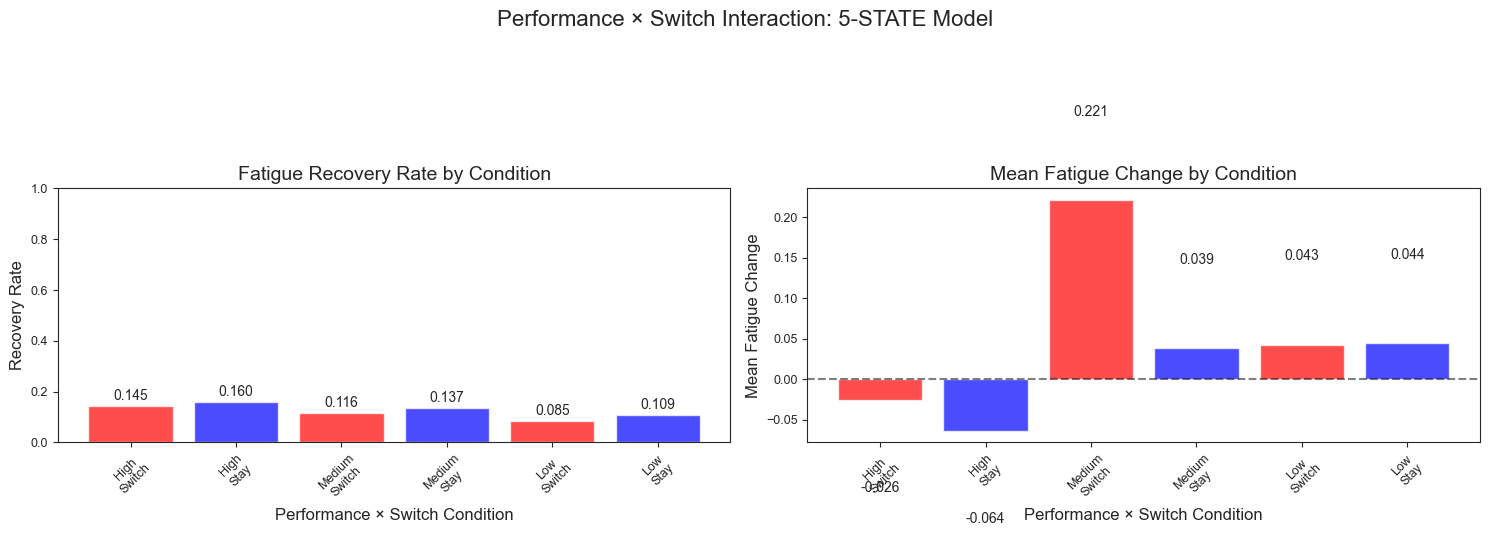


5. SUMMARY OF FINDINGS
----------------------------------------
High performance + Switch recovery rate: 0.145
High performance + Stay recovery rate: 0.160

END OF 5-STATE MODEL INTERACTION ANALYSIS



In [21]:
# Previous Performance × Task Switching
# =========================================================

print("INTERACTION ANALYSIS: Previous Performance × Task Switching")
print("="*60)

for model_name in ['3-state', '5-state']:
    print(f"\n{model_name.upper()} MODEL:")
    print("-" * 40)
    
    # Get the model
    curr_model = models_data[model_name]['model']
    n_states = curr_model.n_components
    
    # Predict states for all subjects
    subject_state_sequences = {}
    for subject_id in test_subjects:
        subj = subject_data[subject_id]
        accuracy = np.array(subj['epoch_accuracy'])
        rest_duration = np.array(subj['post_epoch_post_cue_rest_duration']) / 20
        obs = np.column_stack([accuracy, rest_duration])
        state_seq = curr_model.predict(obs)
        subject_state_sequences[subject_id] = state_seq
    
    # Define fatigue order
    if model_name == '3-state':
        fatigue_order = [0, 1, 2]
    elif model_name == '5-state':
        fatigue_order = [0, 1, 2, 4, 3]
    
    # Collect data for interaction analysis
    interaction_data = []
    
    for subject_id in test_subjects:
        subj = subject_data[subject_id]
        state_seq = subject_state_sequences[subject_id]
        switch_info = subj['epoch_follows_task_switch']
        accuracy = np.array(subj['epoch_accuracy'])
        
        for t in range(len(state_seq) - 1):
            # Skip first epoch (no switch info)
            if t == 0:
                continue
            
            from_state = state_seq[t]
            to_state = state_seq[t + 1]
            is_switch = switch_info[t] == 1
            prev_accuracy = accuracy[t]  # Performance in the current epoch
            
            # Categorize previous performance (you can adjust these thresholds)
            if prev_accuracy >= 0.8:
                perf_category = "High"
            elif prev_accuracy >= 0.6:
                perf_category = "Medium"
            else:
                perf_category = "Low"
            
            # Calculate fatigue change
            from_fatigue = fatigue_order.index(from_state)
            to_fatigue = fatigue_order.index(to_state)
            fatigue_change = to_fatigue - from_fatigue  # Positive = more fatigue, Negative = recovery
            
            interaction_data.append({
                'subject': subject_id,
                'epoch': t + 1,
                'from_state': from_state,
                'to_state': to_state,
                'is_switch': is_switch,
                'prev_accuracy': prev_accuracy,
                'perf_category': perf_category,
                'fatigue_change': fatigue_change,
                'recovery': fatigue_change < 0,  # True if recovered (less fatigue)
                'worse': fatigue_change > 0      # True if got worse (more fatigue)
            })
    
    interaction_df = pd.DataFrame(interaction_data)
    
    print(f"Total transitions analyzed: {len(interaction_df)}")
    
    # 1. Descriptive analysis by condition
    print(f"\n1. DESCRIPTIVE ANALYSIS BY CONDITION")
    print(f"{'-'*40}")
    
    # Group by performance and switch condition
    for perf_cat in ["High", "Medium", "Low"]:
        for switch_cond in [True, False]:
            subset = interaction_df[
                (interaction_df['perf_category'] == perf_cat) & 
                (interaction_df['is_switch'] == switch_cond)
            ]
            
            if len(subset) > 0:
                recovery_rate = subset['recovery'].mean()
                worse_rate = subset['worse'].mean()
                mean_fatigue_change = subset['fatigue_change'].mean()
                
                switch_label = "Switch" if switch_cond else "Stay"
                print(f"{perf_cat} Performance + {switch_label}:")
                print(f"  N = {len(subset)}, Recovery rate = {recovery_rate:.3f}, "
                      f"Worse rate = {worse_rate:.3f}, Mean fatigue change = {mean_fatigue_change:.3f}")
    
    # 2. Statistical analysis
    print(f"\n2. STATISTICAL ANALYSIS")
    print(f"{'-'*40}")
    
    # Chi-square test for recovery rates across all conditions
    from scipy.stats import chi2_contingency
    
    # Create contingency table: Performance × Switch × Recovery
    contingency_data = []
    for perf_cat in ["High", "Medium", "Low"]:
        for switch_cond in [True, False]:
            subset = interaction_df[
                (interaction_df['perf_category'] == perf_cat) & 
                (interaction_df['is_switch'] == switch_cond)
            ]
            
            if len(subset) > 0:
                recovery_count = subset['recovery'].sum()
                no_recovery_count = len(subset) - recovery_count
                contingency_data.append([recovery_count, no_recovery_count])
            else:
                contingency_data.append([0, 0])
    
    if len(contingency_data) == 6:  # 3 performance levels × 2 switch conditions
        contingency_table = np.array(contingency_data).reshape(3, 2, 2)
        
        # Test for interaction effect
        # Flatten to 2D: (Performance×Switch) × Recovery
        flat_table = contingency_table.reshape(6, 2)
        
        chi2, p_value, dof, expected = chi2_contingency(flat_table)
        print(f"Chi-square test for Performance × Switch × Recovery interaction:")
        print(f"  Chi2 = {chi2:.3f}, p = {p_value:.4f}, df = {dof}")
        
        if p_value < 0.05:
            print(f"  *** SIGNIFICANT interaction effect! ***")
        else:
            print(f"  No significant interaction effect")
    
    # 3. Logistic regression analysis
    print(f"\n3. LOGISTIC REGRESSION ANALYSIS")
    print(f"{'-'*40}")
    
    try:
        from sklearn.linear_model import LogisticRegression
        from sklearn.preprocessing import LabelEncoder
        
        # Prepare data for logistic regression
        X_data = interaction_df[['prev_accuracy', 'is_switch']].copy()
        
        # Add interaction term
        X_data['accuracy_x_switch'] = X_data['prev_accuracy'] * X_data['is_switch']
        
        # Encode categorical variables if needed
        le = LabelEncoder()
        y_data = le.fit_transform(interaction_df['perf_category'])
        
        # Fit logistic regression
        lr = LogisticRegression(random_state=42, max_iter=1000)
        lr.fit(X_data, interaction_df['recovery'])
        
        # Get coefficients
        coefs = lr.coef_[0]
        intercept = lr.intercept_[0]
        
        print(f"Logistic regression coefficients:")
        print(f"  Intercept: {intercept:.3f}")
        print(f"  Previous Accuracy: {coefs[0]:.3f}")
        print(f"  Task Switch: {coefs[1]:.3f}")
        print(f"  Accuracy × Switch: {coefs[2]:.3f}")
        
        # Test significance of interaction term
        if abs(coefs[2]) > 0.1:  # Rough threshold for meaningful interaction
            print(f"  *** INTERACTION TERM IS MEANINGFUL ***")
            if coefs[2] > 0:
                print(f"  Positive interaction: Task switching amplifies the effect of performance")
            else:
                print(f"  Negative interaction: Task switching dampens the effect of performance")
        else:
            print(f"  No meaningful interaction effect")
            
    except ImportError:
        print("  sklearn not available for logistic regression")
    
    # 4. Visualization
    print(f"\n4. VISUALIZATION")
    print(f"{'-'*40}")
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'Performance × Switch Interaction: {model_name.upper()} Model', fontsize=16)
    
    # Plot 1: Recovery rates by condition
    ax1 = axes[0]
    
    # Calculate recovery rates for each condition
    conditions = []
    recovery_rates = []
    
    for perf_cat in ["High", "Medium", "Low"]:
        for switch_cond in [True, False]:
            subset = interaction_df[
                (interaction_df['perf_category'] == perf_cat) & 
                (interaction_df['is_switch'] == switch_cond)
            ]
            
            if len(subset) > 0:
                recovery_rate = subset['recovery'].mean()
                conditions.append(f"{perf_cat}\n{'Switch' if switch_cond else 'Stay'}")
                recovery_rates.append(recovery_rate)
    
    bars = ax1.bar(range(len(conditions)), recovery_rates, 
                   color=['red', 'blue', 'red', 'blue', 'red', 'blue'], alpha=0.7)
    ax1.set_xlabel('Performance × Switch Condition')
    ax1.set_ylabel('Recovery Rate')
    ax1.set_title('Fatigue Recovery Rate by Condition')
    ax1.set_xticks(range(len(conditions)))
    ax1.set_xticklabels(conditions, rotation=45)
    ax1.set_ylim(0, 1)
    
    # Add value labels
    for bar, rate in zip(bars, recovery_rates):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{rate:.3f}', ha='center', va='bottom')
    
    # Plot 2: Mean fatigue change by condition
    ax2 = axes[1]
    
    fatigue_changes = []
    for perf_cat in ["High", "Medium", "Low"]:
        for switch_cond in [True, False]:
            subset = interaction_df[
                (interaction_df['perf_category'] == perf_cat) & 
                (interaction_df['is_switch'] == switch_cond)
            ]
            
            if len(subset) > 0:
                mean_change = subset['fatigue_change'].mean()
                fatigue_changes.append(mean_change)
    
    bars2 = ax2.bar(range(len(conditions)), fatigue_changes,
                    color=['red', 'blue', 'red', 'blue', 'red', 'blue'], alpha=0.7)
    ax2.set_xlabel('Performance × Switch Condition')
    ax2.set_ylabel('Mean Fatigue Change')
    ax2.set_title('Mean Fatigue Change by Condition')
    ax2.set_xticks(range(len(conditions)))
    ax2.set_xticklabels(conditions, rotation=45)
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Add value labels
    for bar, change in zip(bars2, fatigue_changes):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + (0.1 if height >= 0 else -0.1),
                f'{change:.3f}', ha='center', va='bottom' if height >= 0 else 'top')
    
    plt.tight_layout()
    plt.show()
    
    # 5. Summary of findings
    print(f"\n5. SUMMARY OF FINDINGS")
    print(f"{'-'*40}")
    
    # Find the most interesting patterns
    high_switch = interaction_df[(interaction_df['perf_category'] == 'High') & (interaction_df['is_switch'] == True)]
    high_stay = interaction_df[(interaction_df['perf_category'] == 'High') & (interaction_df['is_switch'] == False)]
    
    if len(high_switch) > 0 and len(high_stay) > 0:
        high_switch_recovery = high_switch['recovery'].mean()
        high_stay_recovery = high_stay['recovery'].mean()
        
        print(f"High performance + Switch recovery rate: {high_switch_recovery:.3f}")
        print(f"High performance + Stay recovery rate: {high_stay_recovery:.3f}")
        
        if abs(high_switch_recovery - high_stay_recovery) > 0.05:
            print(f"  *** Notable difference in high performance condition ***")
    
    print(f"\n{'='*60}")
    print(f"END OF {model_name.upper()} MODEL INTERACTION ANALYSIS")
    print(f"{'='*60}\n")